In [1]:
#Imports and Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Name cleanup dictionary
NAME_CLEANUP = {
    'ACBarrett': 'Barrett', 'AMKennedy': 'Kennedy', 'AScalia': 'Scalia',
    'BMKavanaugh': 'Kavanaugh', 'CThomas': 'Thomas', 'DHSouter': 'Souter',
    'EKagan': 'Kagan', 'JGRoberts': 'Roberts', 'JPStevens': 'Stevens',
    'KBJackson': 'Jackson', 'NMGorsuch': 'Gorsuch', 'RBGinsburg': 'Ginsburg',
    'SAAlito': 'Alito', 'SDOConnor': "O'Connor", 'SGBreyer': 'Breyer',
    'SSotomayor': 'Sotomayor', 'WHRehnquist': 'Rehnquist', 'HLBlack': 'Black',
    'WODouglas': 'Douglas', 'FFrankfurter': 'Frankfurter', 'RHJackson': 'Jackson',
    'TCClark': 'Clark', 'SMinton': 'Minton', 'BRWhite': 'White',
    'AJGoldberg': 'Goldberg', 'AFortas': 'Fortas', 'TMarshall': 'Marshall',
    'WEBurger': 'Burger', 'HABlackmun': 'Blackmun', 'LFPowell': 'Powell',
    'CEWhittaker': 'Whittaker', 'PStewart': 'Stewart', 'WJBrennan': 'Brennan',
    'EWarren': 'Warren', 'JHarlan2': 'Harlan'
}

# Appointing president information
APPOINTING_PRESIDENT = {
    'HLBlack': ('Roosevelt', 'D'), 'WODouglas': ('Roosevelt', 'D'),
    'FFrankfurter': ('Roosevelt', 'D'), 'RHJackson': ('Roosevelt', 'D'),
    'TCClark': ('Truman', 'D'), 'SMinton': ('Truman', 'D'),
    'BRWhite': ('Kennedy', 'D'), 'AJGoldberg': ('Kennedy', 'D'),
    'AFortas': ('Johnson', 'D'), 'TMarshall': ('Johnson', 'D'),
    'RBGinsburg': ('Clinton', 'D'), 'SGBreyer': ('Clinton', 'D'),
    'SSotomayor': ('Obama', 'D'), 'EKagan': ('Obama', 'D'),
    'KBJackson': ('Biden', 'D'), 'SFReed': ('Truman', 'D'),
    'EWarren': ('Eisenhower', 'R'), 'WJBrennan': ('Eisenhower', 'R'),
    'CEWhittaker': ('Eisenhower', 'R'), 'PStewart': ('Eisenhower', 'R'),
    'JHarlan2': ('Eisenhower', 'R'), 'WEBurger': ('Nixon', 'R'),
    'HABlackmun': ('Nixon', 'R'), 'LFPowell': ('Nixon', 'R'),
    'WHRehnquist': ('Nixon', 'R'), 'JPStevens': ('Ford', 'R'),
    'SDOConnor': ('Reagan', 'R'), 'AScalia': ('Reagan', 'R'),
    'AMKennedy': ('Reagan', 'R'), 'DHSouter': ('Bush', 'R'),
    'CThomas': ('Bush', 'R'), 'JGRoberts': ('Bush', 'R'),
    'SAAlito': ('Bush', 'R'), 'NMGorsuch': ('Trump', 'R'),
    'BMKavanaugh': ('Trump', 'R'), 'ACBarrett': ('Trump', 'R'),
    'HHBurton': ('Truman', 'R')
}

# Stable time periods for analysis
STABLE_PERIODS = {
    "Period A (1954-55)": (1954, 1955),
    "Period B (1959-60)": (1959, 1960),
    "Period C (1963-64)": (1963, 1964),
    "Period D (1969-70)": (1969, 1970),
    "Period E (1972-74)": (1972, 1974),
    "Period F (1981-85)": (1981, 1985),
    "Period G (1988-89)": (1988, 1989),
    "Period H (1994-04)": (1994, 2004),
    "Period I (2010-15)": (2010, 2015),
    "Period J (2018-19)": (2018, 2019),
    "Period K (2022-24)": (2022, 2024)
}

print("Configuration loaded successfully")

Configuration loaded successfully


In [2]:
# Core Data Processing Functions

def calculate_agreement_matrix(df, min_cases=100, verbose=True):
    """Calculate pairwise agreement matrix for justices."""
    if verbose:
        print("Calculating agreement matrix...")
    
    justice_names = sorted(df['justiceName'].unique())
    unique_cases = df['caseId'].unique()
    n_justices, n_cases = len(justice_names), len(unique_cases)
    
    if verbose:
        print(f"  {n_justices} justices, {n_cases:,} cases")
    
    if n_justices < 3:
        return None, None, None
    
    justice_idx = {name: i for i, name in enumerate(justice_names)}
    agreements = np.zeros((n_justices, n_justices))
    comparisons = np.zeros((n_justices, n_justices))
    
    for i in range(0, len(unique_cases), 500):
        batch = df[df['caseId'].isin(unique_cases[i:i+500])]
        
        for _, case in batch.groupby('caseId'):
            indices = [justice_idx[j] for j in case['justiceName']]
            votes = case['vote'].values
            
            for p1, i1 in enumerate(indices):
                for p2, i2 in enumerate(indices):
                    comparisons[i1, i2] += 1
                    if votes[p1] == votes[p2]:
                        agreements[i1, i2] += 1
    
    with np.errstate(divide='ignore', invalid='ignore'):
        agreement_matrix = np.divide(agreements, comparisons)
        agreement_matrix = np.nan_to_num(agreement_matrix, nan=0.0)
    
    np.fill_diagonal(agreement_matrix, 1.0)
    
    metadata = {
        'n_justices': n_justices,
        'n_cases': n_cases,
        'mean_comparisons': float(comparisons[comparisons > 0].mean()) if comparisons.any() else 0
    }
    
    if verbose:
        print("  Agreement matrix completed")
    
    return agreement_matrix, justice_names, metadata

def create_distance_matrix(agreement_matrix):
    """Convert agreement to distance."""
    return 1 - agreement_matrix

def get_appointing_president(justice_name):
    """Get president info."""
    return APPOINTING_PRESIDENT.get(justice_name, (None, None))

def clean_justice_names(justice_names):
    """Clean names for display."""
    return [NAME_CLEANUP.get(name, name[:10]) for name in justice_names]

print("Core data processing functions loaded")

Core data processing functions loaded


In [3]:
# Dimensionality Reduction Functions

def run_mds(distance_matrix, n_components=2, random_state=42, verbose=True):
    """Run MDS."""
    if verbose:
        print(f"Running MDS ({n_components}D)...")
    
    mds = MDS(n_components=n_components, dissimilarity='precomputed', 
              random_state=random_state)
    coords = mds.fit_transform(distance_matrix)
    
    indices = np.triu_indices(len(distance_matrix), k=1)
    r_squared = pearsonr(distance_matrix[indices], 
                        squareform(pdist(coords))[indices])[0] ** 2
    
    fit_quality = ("Excellent" if mds.stress_ < 0.05 else
                   "Good" if mds.stress_ < 0.1 else
                   "Fair" if mds.stress_ < 0.2 else "Poor")
    
    metrics = {'stress': mds.stress_, 'r_squared': r_squared, 
               'fit_quality': fit_quality, 'n_components': n_components}
    
    if verbose:
        print(f"  Stress: {mds.stress_:.3f} ({fit_quality}), R²: {r_squared:.3f}")
    
    return coords, mds, metrics

def run_pca(agreement_matrix, n_components=2, verbose=True):
    """Run PCA."""
    if verbose:
        print(f"Running PCA ({n_components}D)...")
    
    pca = PCA(n_components=n_components)
    coords = pca.fit_transform(agreement_matrix)
    
    metrics = {
        'variance_explained': pca.explained_variance_ratio_,
        'cumulative_variance': pca.explained_variance_ratio_.sum(),
        'n_components': n_components
    }
    
    if verbose:
        print(f"  Variance: {metrics['cumulative_variance']*100:.1f}%")
    
    return coords, pca, metrics

print("Dimensionality reduction functions loaded")

Dimensionality reduction functions loaded


In [4]:
# Visualization Functions

def setup_plotting_style():
    """Configure plotting."""
    plt.rcParams.update({
        'figure.figsize': (12, 8), 'figure.dpi': 100,
        'font.size': 11, 'axes.grid': True, 'grid.alpha': 0.3
    })
    try:
        sns.set_palette("husl")
    except:
        pass

def save_figure(fig, filename, dpi=300):
    """Save figure."""
    import os
    os.makedirs('assets/images', exist_ok=True)
    path = f'assets/images/{filename}.png'
    fig.savefig(path, dpi=dpi, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"Saved: {path}")
    return path

def plot_mds_2d(coords, justice_names, color_by='president_party', 
                title='MDS Plot', ax=None, show_labels=True):
    """Create 2D MDS plot."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    clean_names = clean_justice_names(justice_names)
    
    if color_by == 'president_party':
        color_map = {'R': 'red', 'D': 'blue', None: 'gray'}
        colors = [color_map[get_appointing_president(n)[1]] for n in justice_names]
    else:
        colors = 'steelblue'
    
    ax.scatter(coords[:, 0], coords[:, 1], c=colors, s=100, 
               alpha=0.7, edgecolors='white', linewidth=1.5)
    
    if show_labels:
        for i, name in enumerate(clean_names):
            ax.annotate(name, (coords[i, 0], coords[i, 1]), 
                       xytext=(4, 4), textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                alpha=0.8, edgecolor='gray'))
    
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_xlabel('Dimension 1', fontsize=12)
    ax.set_ylabel('Dimension 2', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    return ax

def plot_agreement_heatmap(agreement_matrix, justice_names, ax=None):
    """Create agreement heatmap."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    
    clean_names = clean_justice_names(justice_names)
    im = ax.imshow(agreement_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
    
    ax.set_xticks(range(len(clean_names)))
    ax.set_yticks(range(len(clean_names)))
    ax.set_xticklabels(clean_names, rotation=45, ha='right')
    ax.set_yticklabels(clean_names)
    
    plt.colorbar(im, ax=ax, label='Agreement Rate')
    ax.set_title('Justice Agreement Matrix', fontsize=14, pad=15)
    
    return ax

# Initialize plotting style
setup_plotting_style()
print("Visualization functions loaded")

Visualization functions loaded


In [5]:
# Temporal Analysis Functions

def plot_temporal_mds(results_dict, save_path=None):
    """Plot MDS across time periods."""
    n = len(results_dict)
    rows, cols = (n + 3) // 4, 4
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for idx, (name, res) in enumerate(results_dict.items()):
        if res is None:
            axes[idx].text(0.5, 0.5, f'Insufficient data\n{name}',
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue
        
        plot_mds_2d(res['mds_coords'], res['justice_names'], 
                   title=f"{name}\nStress: {res['mds_metrics']['stress']:.3f}",
                   ax=axes[idx])
    
    for idx in range(n, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    if save_path:
        save_figure(fig, save_path)
    plt.show()
    return fig

def create_temporal_summary_table(results_dict):
    """Create summary table."""
    data = []
    for name, res in results_dict.items():
        if res is None:
            data.append({'Period': name, 'Justices': 0, 'Cases': 0,
                        'MDS_Stress': np.nan, 'Fit_Quality': 'N/A'})
        else:
            data.append({
                'Period': name,
                'Justices': res['metadata']['n_justices'],
                'Cases': res['metadata']['n_cases'],
                'MDS_Stress': res['mds_metrics']['stress'],
                'Fit_Quality': res['mds_metrics']['fit_quality']
            })
    return pd.DataFrame(data)

#def analyze_pairwise_agreements_over_time(df, time_buckets=None):
    """Analyze pair agreements over time."""
#    if time_buckets is None:
#        time_buckets = [(y, y+9) for y in range(1953, 2024, 10)]
    
#    all_data = []
    
#    for start, end in time_buckets:
#        period = df[(df['term'] >= start) & (df['term'] <= end)]
#        if len(period) == 0:
#            continue
        
#        for j1, j2 in combinations(period['justiceName'].unique(), 2):
#            cases1 = period[period['justiceName'] == j1]
#            cases2 = period[period['justiceName'] == j2]
#            common = set(cases1['caseId']) & set(cases2['caseId'])
            
#            if len(common) < 100:
#                continue
            
#            agree = sum(1 for c in common if 
#                       cases1[cases1['caseId']==c]['vote'].iloc[0] ==
#                       cases2[cases2['caseId']==c]['vote'].iloc[0])
            
#            p1, p2 = get_appointing_president(j1)[1], get_appointing_president(j2)[1]
#            pair_type = ('Both D' if p1 == p2 == 'D' else
#                        'Both R' if p1 == p2 == 'R' else
#                        'Mixed' if p1 != p2 and None not in [p1, p2] else None)
            
#            if pair_type:
#                all_data.append({
#                    'period': f"{start}-{end}",
#                    'agreement_rate': agree / len(common),
#                    'n_cases': len(common),
#                    'pair_type': pair_type
#                })
    
#    return pd.DataFrame(all_data)

#def analyze_coalition_sizes(df):
    """Analyze coalition sizes."""
#    data = []
#    for case_id, votes in df.groupby('caseId'):
#        counts = votes['vote'].value_counts()
#        total = len(votes)
#        if total >= 5:
#            data.append({
#                'term': votes['term'].iloc[0],
#                'majority_size': counts.get(1, 0),
#                'dissent_size': counts.get(2, 0),
#                'margin': counts.get(1, 0) - counts.get(2, 0)
#            })
#    return pd.DataFrame(data)

print("Temporal analysis functions loaded")

Temporal analysis functions loaded


In [6]:
# Advanced Analysis Functions

#def identify_swing_justices(df, period_df, justice_names, threshold=0.45):
#    """
#    Identify swing justices - those who are pivotal in close decisions.
#    Returns justices with high variance in agreement across the court.
#    """
#    print("\n--- Swing Justice Analysis ---")
    
#    agreement_matrix, _, _ = calculate_agreement_matrix(period_df, verbose=False)
#    if agreement_matrix is None:
#        return None
    
    # Calculate variance in agreement rates for each justice
#   swing_scores = []
#   for i, justice in enumerate(justice_names):
#       agreements = agreement_matrix[i, :]
        # Exclude self-agreement
#       agreements = np.delete(agreements, i)
#       variance = np.var(agreements)
#       mean_agreement = np.mean(agreements)
        
        # Swing justices have moderate mean agreement and high variance
#       swing_score = variance * (1 - abs(mean_agreement - 0.5))
        
#       swing_scores.append({
#            'Justice': NAME_CLEANUP.get(justice, justice),
#            'Swing_Score': swing_score,
#            'Mean_Agreement': mean_agreement,
#            'Agreement_Variance': variance
#        })
    
#    swing_df = pd.DataFrame(swing_scores).sort_values('Swing_Score', ascending=False)
#    print(swing_df.head(3))
#    return swing_df

#def calculate_ideological_scores(agreement_matrix, justice_names):
#    """
#    Calculate ideological scores using first principal component of agreement matrix.
#    Similar to Martin-Quinn scores but based on agreement patterns.
#    """
#    print("\n--- Ideological Positioning ---")
    
#    pca = PCA(n_components=1)
#    scores = pca.fit_transform(agreement_matrix).flatten()
    
    # Normalize to -1 to 1 scale
#    scores = (scores - scores.min()) / (scores.max() - scores.min()) * 2 - 1
    
#    ideology_df = pd.DataFrame({
#        'Justice': [NAME_CLEANUP.get(j, j) for j in justice_names],
#        'Ideological_Score': scores,
#       'Party': [get_appointing_president(j)[1] for j in justice_names]
#    }).sort_values('Ideological_Score')
    
#    print(ideology_df)
#    return ideology_df

def analyze_dissent_patterns(df, period_df, justice_names):
    """
    Analyze dissent patterns - who dissents most often and with whom.
    """
    print("\n--- Dissent Pattern Analysis ---")
    
    dissent_data = []
    
    for case_id, case in period_df.groupby('caseId'):
        if len(case) < 5:
            continue
        
        vote_counts = case['vote'].value_counts()
        if len(vote_counts) < 2:
            continue
        
        majority_vote = vote_counts.idxmax()
        dissenters = case[case['vote'] != majority_vote]['justiceName'].tolist()
        
        for justice in dissenters:
            dissent_data.append({
                'Justice': NAME_CLEANUP.get(justice, justice),
                'Case': case_id,
                'Dissent_Size': len(dissenters)
            })
    
    if not dissent_data:
        return None
    
    dissent_df = pd.DataFrame(dissent_data)
    dissent_summary = dissent_df.groupby('Justice').agg({
        'Case': 'count',
        'Dissent_Size': 'mean'
    }).rename(columns={'Case': 'Total_Dissents', 'Dissent_Size': 'Avg_Dissent_Size'})
    
    dissent_summary = dissent_summary.sort_values('Total_Dissents', ascending=False)
    print(dissent_summary.head())
    return dissent_summary

def detect_voting_blocs(agreement_matrix, justice_names, n_clusters=3):
    """
    Detect voting blocs using hierarchical clustering.
    """
    print(f"\n--- Voting Bloc Detection ({n_clusters} blocs) ---")
    
    distance_matrix = 1 - agreement_matrix
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    bloc_df = pd.DataFrame({
        'Justice': [NAME_CLEANUP.get(j, j) for j in justice_names],
        'Bloc': clusters,
        'Party': [get_appointing_president(j)[1] for j in justice_names]
    }).sort_values(['Bloc', 'Justice'])
    
    print(bloc_df)
    return bloc_df, linkage_matrix

#def analyze_case_characteristics(df, period_df):
#    """
#    Analyze how case characteristics relate to voting patterns.
#    """
#    print("\n--- Case Characteristics Analysis ---")
    
#    if 'issueArea' not in period_df.columns:
#        print("Issue area data not available")
#        return None
    
#    case_stats = []
#    for case_id, case in period_df.groupby('caseId'):
#        if len(case) < 5:
#            continue
        
#        vote_counts = case['vote'].value_counts()
#        if len(vote_counts) < 1:
#            continue
        
#        case_stats.append({
#            'Issue_Area': case['issueArea'].iloc[0] if 'issueArea' in case else 'Unknown',
#            'Unanimity': len(vote_counts) == 1,
#            'Margin': vote_counts.iloc[0] - (vote_counts.iloc[1] if len(vote_counts) > 1 else 0),
#            'Justices_Voting': len(case)
#        })
    
#    if not case_stats:
#        return None
    
#    char_df = pd.DataFrame(case_stats)
#    summary = char_df.groupby('Issue_Area').agg({
#        'Unanimity': 'mean',
#        'Margin': 'mean',
#        'Justices_Voting': 'count'
#    }).rename(columns={'Justices_Voting': 'N_Cases'})
    
#    print(summary.sort_values('Unanimity', ascending=False).head())
#    return summary

#def predict_justice_votes(df, period_df, justice_names):
#    """
#    Build predictive model for justice votes based on case characteristics and other justices' votes.
#    """
#   print("\n--- Vote Prediction Model ---")
    
    # Prepare feature matrix
#    features_list = []
#    labels_list = []
#    justice_list = []
    
#    for case_id, case in period_df.groupby('caseId'):
#        if len(case) < 5:
#            continue
        
#        case_votes = dict(zip(case['justiceName'], case['vote']))
        
#        for target_justice in case['justiceName']:
            # Features: votes of other justices
#            other_votes = [case_votes[j] for j in justice_names if j in case_votes and j != target_justice]
            
            # Filter out NaN values
#            other_votes = [v for v in other_votes if pd.notna(v)]
            
#            if len(other_votes) >= 4:  # Need enough other justices
#                features_list.append(other_votes[:8])  # Limit to 8 features
#                label = case_votes[target_justice]
#                if pd.notna(label):  # Only add if target vote is not NaN
#                    labels_list.append(label)
#                    justice_list.append(target_justice)
#                else:
#                    features_list.pop()  # Remove the features we just added
    
#    if len(features_list) < 50:
#        print("Insufficient data for prediction")
#        return None
    
    # Pad features to consistent length
#    max_len = max(len(f) for f in features_list)
#    features_list = [f + [0] * (max_len - len(f)) for f in features_list]
    
#    X = np.array(features_list)
#    y = np.array(labels_list)
    
    # Additional cleaning: remove any rows with NaN or inf
#    valid_mask = ~(np.isnan(X).any(axis=1) | np.isinf(X).any(axis=1) | 
#                   np.isnan(y) | np.isinf(y))
#    X = X[valid_mask]
#    y = y[valid_mask]
#    justice_list = [justice_list[i] for i, v in enumerate(valid_mask) if v]
    
#    if len(X) < 50:
#        print("Insufficient clean data for prediction after removing NaN/inf")
#        return None
    
    # Convert to integers if needed
#    y = y.astype(int)
    
#    print(f"Training on {len(X)} samples with {X.shape[1]} features")
    
    # Train random forest
#    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
#    try:
#        cv_folds = min(5, len(X)//20)
#        if cv_folds < 2:
#            print("Not enough data for cross-validation")
#            return None
#        scores = cross_val_score(rf, X, y, cv=cv_folds)
#        print(f"Vote prediction accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")
#    except Exception as e:
#        print(f"Could not train prediction model: {str(e)}")
#        return None
    
    # Identify most predictable justices
#    justice_accuracy = {}
#    for justice in set(justice_list):
#        justice_mask = np.array(justice_list) == justice
#        if justice_mask.sum() > 10:
#            try:
#                justice_scores = cross_val_score(rf, X[justice_mask], y[justice_mask], 
#                                                cv=min(3, justice_mask.sum()//5))
#                justice_accuracy[NAME_CLEANUP.get(justice, justice)] = justice_scores.mean()
#            except:
#                continue
    
#    if not justice_accuracy:
#        print("Could not calculate individual justice predictability")
#        return None
    
#    predictability_df = pd.DataFrame(list(justice_accuracy.items()), 
#                                     columns=['Justice', 'Predictability']
#                                    ).sort_values('Predictability', ascending=False)
#    
#    print("\nMost predictable justices:")
#    print(predictability_df.head())
    
#    return predictability_df

#def analyze_temporal_drift(df, justice_name, window_years=3):
#    """
#    Analyze how a justice's voting patterns change over their tenure.
#    """
#    print(f"\n--- Temporal Drift Analysis: {NAME_CLEANUP.get(justice_name, justice_name)} ---")
    
#    justice_df = df[df['justiceName'] == justice_name].sort_values('term')
    
#    if len(justice_df) < 100:
#        print("Insufficient data for this justice")
#        return None
    
#    terms = justice_df['term'].unique()
#    drift_data = []
    
#    for i, term in enumerate(terms[:-window_years]):
#        window_df = justice_df[(justice_df['term'] >= term) & 
#                               (justice_df['term'] < term + window_years)]
        
        # Calculate conservatism score (simplified: % of votes in direction 1)
#       conservatism = (window_df['vote'] == 1).mean()
        
#        drift_data.append({
#            'Term': term,
#            'Conservatism_Score': conservatism,
#            'N_Cases': len(window_df)
#        })
    
#    drift_df = pd.DataFrame(drift_data)
    
    # Calculate trend
#    if len(drift_df) > 2:
#        correlation = spearmanr(drift_df['Term'], drift_df['Conservatism_Score'])[0]
#        direction = "conservative" if correlation > 0 else "liberal"
#        print(f"Trend: Moving {direction} over time (ρ = {correlation:.3f})")
    
#    return drift_df

#def compare_cross_period_justices(results_dict):
#    """
#    Compare justices who served in multiple periods to track changes.
#    """
#    print("\n--- Cross-Period Justice Comparison ---")
    
#    justice_periods = {}
    
#    for period_name, result in results_dict.items():
#        if result is None:
#            continue
        
#        for justice in result['justice_names']:
#            if justice not in justice_periods:
#                justice_periods[justice] = []
            
            # Find this justice's ideological position in this period
#            idx = result['justice_names'].index(justice)
#            position = result['mds_coords'][idx]
            
#            justice_periods[justice].append({
#                'Period': period_name,
#                'Years': result['years'],
#                'Position_X': position[0],
#                'Position_Y': position[1]
#            })
    
    # Find justices in multiple periods
#    multi_period = {j: periods for j, periods in justice_periods.items() if len(periods) >= 2}
    
#    if not multi_period:
#        print("No justices found serving in multiple analyzed periods")
#        return None
    
#    print(f"Found {len(multi_period)} justices serving in multiple periods:")
#    for justice, periods in list(multi_period.items())[:5]:
#        print(f"  {NAME_CLEANUP.get(justice, justice)}: {len(periods)} periods")
    
#    return multi_period

#def plot_advanced_analyses(period_result, dissent_summary, ideology_df, bloc_df):
#    """
#    Create comprehensive visualization of advanced analyses.
#    """
#    fig = plt.figure(figsize=(20, 12))
#    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Ideological spectrum
#    ax1 = fig.add_subplot(gs[0, :])
#    colors = ['blue' if p == 'D' else 'red' if p == 'R' else 'gray' 
#              for p in ideology_df['Party']]
#    ax1.barh(ideology_df['Justice'], ideology_df['Ideological_Score'], color=colors, alpha=0.7)
#    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
#    ax1.set_xlabel('Ideological Score (Liberal ← → Conservative)')
#    ax1.set_title('Justice Ideological Positioning', fontsize=14, fontweight='bold')
#    ax1.grid(True, alpha=0.3)
    
    # 2. Dissent patterns
#    if dissent_summary is not None and len(dissent_summary) > 0:
#        ax2 = fig.add_subplot(gs[1, 0])
#        top_dissenters = dissent_summary.head(8)
#        ax2.barh(top_dissenters.index, top_dissenters['Total_Dissents'], color='coral')
#        ax2.set_xlabel('Number of Dissents')
#        ax2.set_title('Most Frequent Dissenters', fontsize=12, fontweight='bold')
#        ax2.grid(True, alpha=0.3)
    
    # 3. Voting blocs
#    ax3 = fig.add_subplot(gs[1, 1])
#    bloc_colors = plt.cm.Set3(np.linspace(0, 1, len(bloc_df['Bloc'].unique())))
#    for bloc_num, color in zip(sorted(bloc_df['Bloc'].unique()), bloc_colors):
#        bloc_justices = bloc_df[bloc_df['Bloc'] == bloc_num]
#        ax3.scatter([bloc_num] * len(bloc_justices), range(len(bloc_justices)), 
#                   c=[color], s=200, alpha=0.7)
#        for i, justice in enumerate(bloc_justices['Justice']):
#            ax3.text(bloc_num, i, justice, ha='center', va='center', fontsize=9)
#    ax3.set_xlabel('Voting Bloc')
#    ax3.set_ylabel('Justice')
#    ax3.set_title('Detected Voting Blocs', fontsize=12, fontweight='bold')
#    ax3.set_xticks(sorted(bloc_df['Bloc'].unique()))
#    ax3.grid(True, alpha=0.3)
    
    # 4. Agreement heatmap
#    ax4 = fig.add_subplot(gs[1, 2])
#    plot_agreement_heatmap(period_result['agreement_matrix'], 
#                          period_result['justice_names'], ax=ax4)
#    ax4.set_title('Agreement Heatmap', fontsize=12, fontweight='bold')
    
    # 5. MDS visualization with blocs
#    ax5 = fig.add_subplot(gs[2, :2])
#    bloc_map = dict(zip(bloc_df['Justice'], bloc_df['Bloc']))
#    clean_names = clean_justice_names(period_result['justice_names'])
#    bloc_colors_mds = [bloc_colors[bloc_map.get(name, 0) - 1] 
#                       for name in clean_names]
    
#    ax5.scatter(period_result['mds_coords'][:, 0], 
#               period_result['mds_coords'][:, 1],
#               c=bloc_colors_mds, s=150, alpha=0.7, edgecolors='white', linewidth=2)
    
#    for i, name in enumerate(clean_names):
#        ax5.annotate(name, (period_result['mds_coords'][i, 0], 
#                           period_result['mds_coords'][i, 1]),
#                    xytext=(4, 4), textcoords='offset points', fontsize=9,
#                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
#                            alpha=0.8, edgecolor='gray'))
    
#    ax5.set_xlabel('Dimension 1')
#    ax5.set_ylabel('Dimension 2')
#    ax5.set_title('MDS with Voting Blocs', fontsize=12, fontweight='bold')
#    ax5.grid(True, alpha=0.3)
    
#    # 6. Coalition size distribution
#    ax6 = fig.add_subplot(gs[2, 2])
    # Placeholder for coalition analysis
#    ax6.text(0.5, 0.5, 'Coalition Size\nAnalysis', ha='center', va='center',
#            fontsize=14, transform=ax6.transAxes)
#    ax6.set_title('Decision Margins', fontsize=12, fontweight='bold')
    
#    plt.suptitle(f"Comprehensive Analysis: {period_result['period_name']}", 
#                fontsize=16, fontweight='bold', y=0.995)
    
#    return fig

print("Advanced analysis functions loaded")

Advanced analysis functions loaded


In [7]:
# Main Workflow Functions

def analyze_court_period(df, period_name, start_year, end_year, 
                         min_decisions=100, run_both=True):
    """Complete analysis for a period."""
    print(f"\n{'='*60}\nAnalyzing {period_name}: {start_year}-{end_year}\n{'='*60}")
    
    period_df = df[(df['term'] >= start_year) & (df['term'] <= end_year)]
    
    agreement_matrix, justice_names, metadata = calculate_agreement_matrix(period_df)
    if agreement_matrix is None:
        return None
    
    distance_matrix = create_distance_matrix(agreement_matrix)
    mds_coords, mds_obj, mds_metrics = run_mds(distance_matrix)
    
    pca_coords, pca_obj, pca_metrics = (run_pca(agreement_matrix) if run_both 
                                        else (None, None, None))
    
    return {
        'period_name': period_name,
        'years': (start_year, end_year),
        'agreement_matrix': agreement_matrix,
        'distance_matrix': distance_matrix,
        'justice_names': justice_names,
        'clean_names': clean_justice_names(justice_names),
        'mds_coords': mds_coords,
        'mds_object': mds_obj,
        'mds_metrics': mds_metrics,
        'pca_coords': pca_coords,
        'pca_metrics': pca_metrics,
        'metadata': metadata
    }

def analyze_all_stable_periods(df, periods_dict=None):
    """Analyze all stable periods."""
    if periods_dict is None:
        periods_dict = STABLE_PERIODS
    
    return {name: analyze_court_period(df, name, start, end)
            for name, (start, end) in periods_dict.items()}

def run_comprehensive_analysis(df, period_name, start_year, end_year):
    """
    Run all analyses for a given period including advanced analyses.
    """
    print(f"\n{'='*70}")
    print(f"COMPREHENSIVE ANALYSIS: {period_name}")
    print(f"{'='*70}")
    
    # Basic analysis
    period_result = analyze_court_period(df, period_name, start_year, end_year)
    
    if period_result is None:
        print("Insufficient data for analysis")
        return None
    
    period_df = df[(df['term'] >= start_year) & (df['term'] <= end_year)]
    
    # Advanced analyses
#    swing_df = identify_swing_justices(df, period_df, period_result['justice_names'])
#    ideology_df = calculate_ideological_scores(period_result['agreement_matrix'], 
#                                               period_result['justice_names'])
    dissent_summary = analyze_dissent_patterns(df, period_df, period_result['justice_names'])
    bloc_df, linkage_mat = detect_voting_blocs(period_result['agreement_matrix'], 
                                               period_result['justice_names'])
#    case_char = analyze_case_characteristics(df, period_df)
#    predictability = predict_justice_votes(df, period_df, period_result['justice_names'])
    
    # Create comprehensive visualization
#    if dissent_summary is not None and ideology_df is not None and bloc_df is not None:
#        fig = plot_advanced_analyses(period_result, dissent_summary, ideology_df, bloc_df)
#        save_figure(fig, f'comprehensive_analysis_{period_name.replace(" ", "_")}')
#        plt.show()
    
    return {
        'basic': period_result,
#       'swing': swing_df,
#        'ideology': ideology_df,
        'dissent': dissent_summary,
        'blocs': bloc_df#,
#        'case_characteristics': case_char#,
#        'predictability': predictability
    }

#def analyze_justice_evolution(df, justice_name):
    """
    Complete temporal analysis of a single justice's evolution.
    """
#    print(f"\n{'='*70}")
#    print(f"JUSTICE EVOLUTION ANALYSIS: {NAME_CLEANUP.get(justice_name, justice_name)}")
#    print(f"{'='*70}")
    
#    drift_df = analyze_temporal_drift(df, justice_name, window_years=3)
    
#    if drift_df is not None:
#        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Conservatism over time
#        axes[0].plot(drift_df['Term'], drift_df['Conservatism_Score'], 
#                    marker='o', linewidth=2, markersize=8)
#        axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
#        axes[0].set_xlabel('Term')
#        axes[0].set_ylabel('Conservatism Score')
#        axes[0].set_title(f'{NAME_CLEANUP.get(justice_name, justice_name)}: Ideological Drift')
#        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Case volume
#        axes[1].bar(drift_df['Term'], drift_df['N_Cases'], alpha=0.7, color='steelblue')
#        axes[1].set_xlabel('Term')
#        axes[1].set_ylabel('Number of Cases')
#        axes[1].set_title('Case Participation Over Time')
#        axes[1].grid(True, alpha=0.3)
        
#        plt.tight_layout()
#        save_figure(fig, f'justice_evolution_{NAME_CLEANUP.get(justice_name, justice_name)}')
#        plt.show()
    
#    return drift_df

def create_executive_summary(results_dict, comprehensive_results=None):
    """
    Create an executive summary of all analyses.
    """
    print("\n" + "="*70)
    print("EXECUTIVE SUMMARY - SCOTUS VOTING PATTERN ANALYSIS")
    print("="*70)
    
    # Basic statistics
    total_justices = sum(r['metadata']['n_justices'] for r in results_dict.values() if r)
    total_cases = sum(r['metadata']['n_cases'] for r in results_dict.values() if r)
    
    print(f"\nDataset Overview:")
    print(f"  • Periods analyzed: {len(results_dict)}")
    print(f"  • Total justice-period combinations: {total_justices}")
    print(f"  • Total cases analyzed: {total_cases:,}")
    
    # Summary table
    summary_df = create_temporal_summary_table(results_dict)
    print(f"\n{summary_df.to_string(index=False)}")
    
    if comprehensive_results:
        print("\n" + "-"*70)
        print("Key Findings from Advanced Analyses:")
        print("-"*70)
        
        for key, value in comprehensive_results.items():
            if value is None:
                continue
            
            if key == 'swing' and value is not None:
                print(f"\n• Top Swing Justice: {value.iloc[0]['Justice']}")
            elif key == 'ideology' and value is not None:
                most_lib = value.iloc[0]['Justice']
                most_con = value.iloc[-1]['Justice']
                print(f"• Most Liberal: {most_lib}")
                print(f"• Most Conservative: {most_con}")
            elif key == 'predictability' and value is not None:
                most_pred = value.iloc[0]['Justice']
                print(f"• Most Predictable Justice: {most_pred}")
    
    print("\n" + "="*70 + "\n")

print("Main workflow functions loaded")
print("\n" + "="*60)
print("All functions loaded successfully!")
print("="*60)
print("\nQuick Start Guide:")
print("  1. Load data: df = pd.read_csv('SCDB_2025_01_V3.csv')")
print("  2. Basic analysis: results = analyze_all_stable_periods(df)")
print("  3. Comprehensive analysis: comp = run_comprehensive_analysis(df, 'Period K (2022-24)', 2022, 2024)")
print("  4. Justice evolution: drift = analyze_justice_evolution(df, 'CThomas')")
print("  5. Executive summary: create_executive_summary(results, comp)")
print("  6. Cross-period comparison: multi = compare_cross_period_justices(results)")
print("="*60)

Main workflow functions loaded

All functions loaded successfully!

Quick Start Guide:
  1. Load data: df = pd.read_csv('SCDB_2025_01_V3.csv')
  2. Basic analysis: results = analyze_all_stable_periods(df)
  3. Comprehensive analysis: comp = run_comprehensive_analysis(df, 'Period K (2022-24)', 2022, 2024)
  4. Justice evolution: drift = analyze_justice_evolution(df, 'CThomas')
  5. Executive summary: create_executive_summary(results, comp)
  6. Cross-period comparison: multi = compare_cross_period_justices(results)



Analyzing Period A (1954-55): 1954-1955
Calculating agreement matrix...
  9 justices, 204 cases
  Agreement matrix completed
Running MDS (2D)...
  Stress: 0.137 (Fair), R²: 0.888
Running PCA (2D)...
  Variance: 81.5%

Analyzing Period B (1959-60): 1959-1960
Calculating agreement matrix...
  9 justices, 275 cases
  Agreement matrix completed
Running MDS (2D)...
  Stress: 0.144 (Fair), R²: 0.901
Running PCA (2D)...
  Variance: 83.0%

Analyzing Period C (1963-64): 1963-1964
Calculating agreement matrix...
  9 justices, 317 cases
  Agreement matrix completed
Running MDS (2D)...
  Stress: 0.155 (Fair), R²: 0.841
Running PCA (2D)...
  Variance: 73.6%

Analyzing Period D (1969-70): 1969-1970
Calculating agreement matrix...
  9 justices, 285 cases
  Agreement matrix completed
Running MDS (2D)...
  Stress: 0.231 (Poor), R²: 0.886
Running PCA (2D)...
  Variance: 64.7%

Analyzing Period E (1972-74): 1972-1974
Calculating agreement matrix...
  9 justices, 513 cases
  Agreement matrix completed
Ru

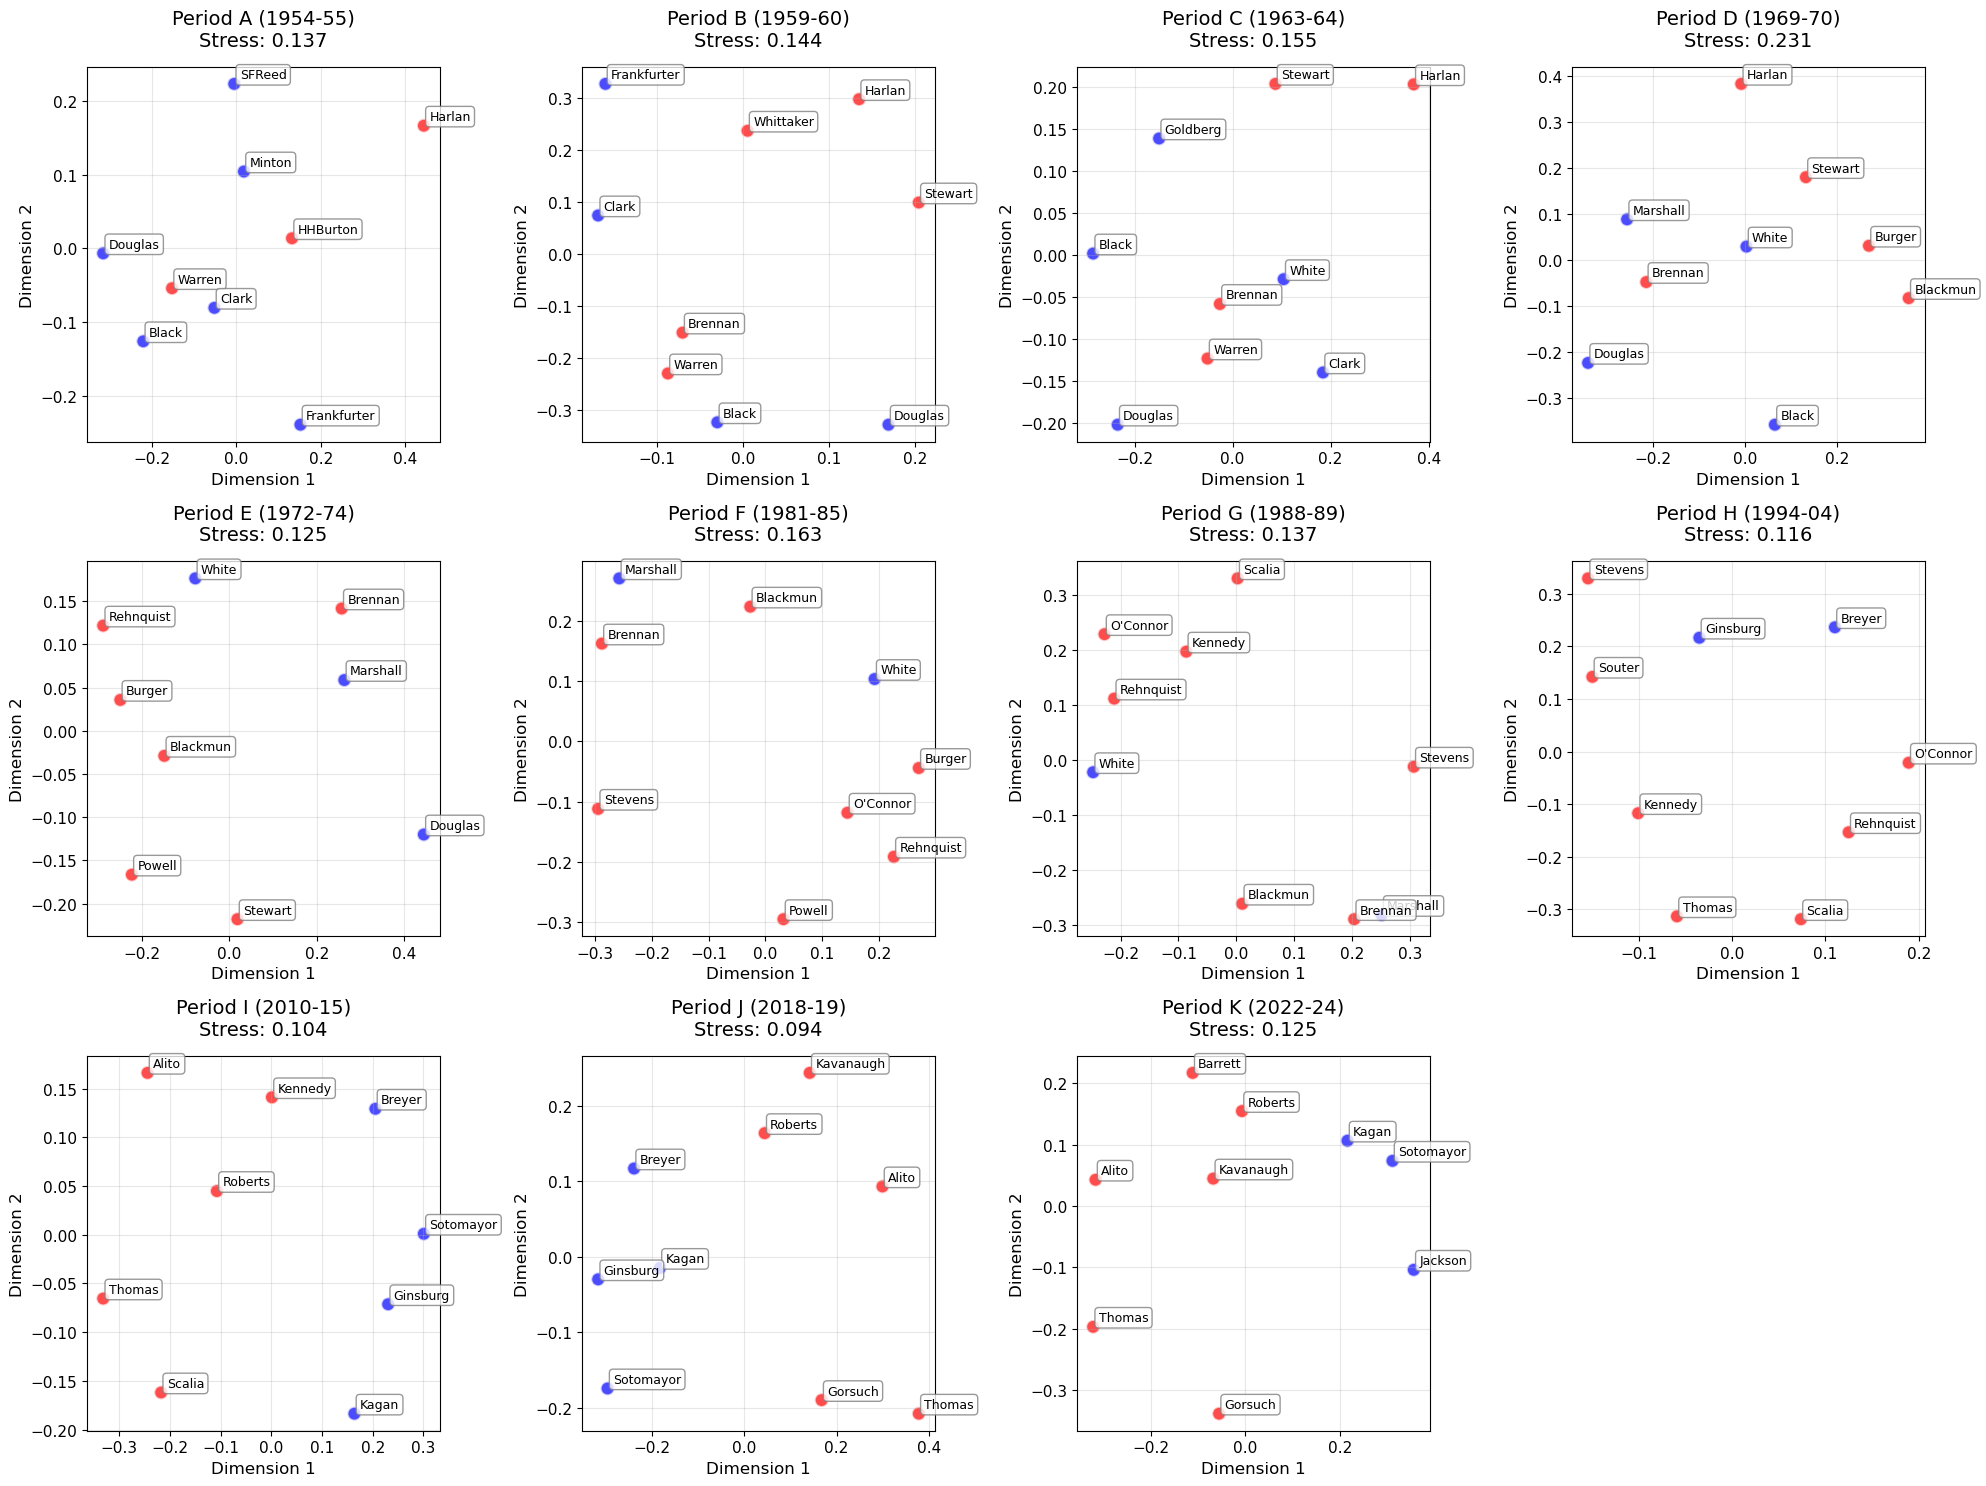

In [8]:
df = pd.read_csv('SCDB_2025_01_V3.csv')
results = analyze_all_stable_periods(df)
plot_temporal_mds(results, 'temporal_mds_analysis')
summary = create_temporal_summary_table(results)

In [9]:
comp = run_comprehensive_analysis(df, 'Period K (2022-24)', 2022, 2024)


COMPREHENSIVE ANALYSIS: Period K (2022-24)

Analyzing Period K (2022-24): 2022-2024
Calculating agreement matrix...
  9 justices, 181 cases
  Agreement matrix completed
Running MDS (2D)...
  Stress: 0.125 (Fair), R²: 0.912
Running PCA (2D)...
  Variance: 81.7%

--- Dissent Pattern Analysis ---
           Total_Dissents  Avg_Dissent_Size
Justice                                    
Thomas                 80          3.650000
Jackson                71          3.535211
Gorsuch                69          3.376812
Alito                  59          3.728814
Sotomayor              56          3.732143

--- Voting Bloc Detection (3 blocs) ---
     Justice  Bloc Party
5    Jackson     1     D
3      Kagan     1     D
8  Sotomayor     1     D
0    Barrett     2     R
1  Kavanaugh     2     R
4    Roberts     2     R
7      Alito     3     R
6    Gorsuch     3     R
2     Thomas     3     R



--- Partisan Agreement Analysis by Decade ---
Processing 1953-1962...
Processing 1963-1972...
Processing 1973-1982...
Processing 1983-1992...
Processing 1993-2002...
Processing 2003-2012...
Processing 2013-2022...
Processing 2023-24...
Saved: assets/images/partisan_agreement_boxplot.png


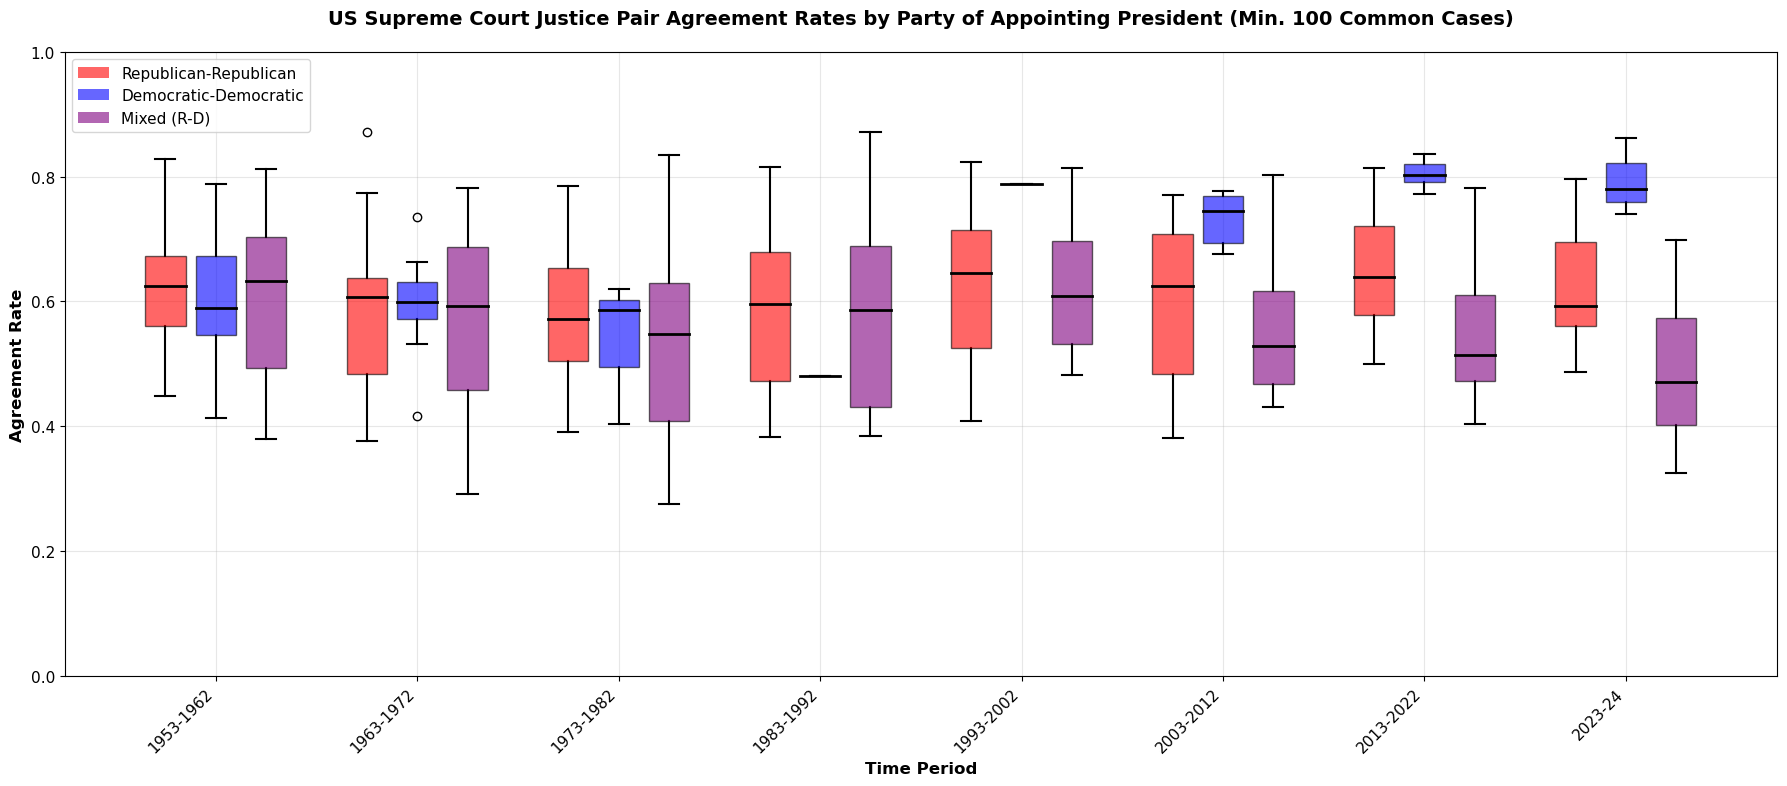


--- Summary Statistics ---
                                Agreement_Rate             
                                          mean    std count
Period    Pair_Type                                        
1953-1962 Democratic-Democratic          0.609  0.101    22
          Mixed                          0.612  0.124    38
          Republican-Republican          0.621  0.096    14
1963-1972 Democratic-Democratic          0.596  0.067    18
          Mixed                          0.575  0.135    42
          Republican-Republican          0.581  0.118    22
1973-1982 Democratic-Democratic          0.537  0.116     3
          Mixed                          0.526  0.143    22
          Republican-Republican          0.583  0.102    27
1983-1992 Democratic-Democratic          0.481    NaN     1
          Mixed                          0.582  0.145    21
          Republican-Republican          0.583  0.122    46
1993-2002 Democratic-Democratic          0.787    NaN     1
          Mi

In [10]:
def plot_partisan_agreement_boxplot(df, save_path='partisan_agreement_boxplot'):
    """
    Create boxplot of justice pair agreement rates by decade, colored by partisan pairing.
    """
    print("\n--- Partisan Agreement Analysis by Decade ---")
    
    # Define time periods
    time_periods = []
    for year in range(1953, 2023, 10):
        time_periods.append((f"{year}-{year+9}", year, year+9))
    time_periods.append(("2023-24", 2023, 2024))
    
    all_data = []
    
    for period_name, start_year, end_year in time_periods:
        print(f"Processing {period_name}...")
        period_df = df[(df['term'] >= start_year) & (df['term'] <= end_year)]
        
        if len(period_df) == 0:
            continue
        
        # Get all justice pairs
        justices = period_df['justiceName'].unique()
        
        for j1, j2 in combinations(justices, 2):
            # Get cases for each justice
            cases1 = period_df[period_df['justiceName'] == j1]
            cases2 = period_df[period_df['justiceName'] == j2]
            
            # Find common cases
            common_cases = set(cases1['caseId']) & set(cases2['caseId'])
            
            if len(common_cases) < 100:
                continue
            
            # Calculate agreement rate
            agreements = 0
            for case_id in common_cases:
                vote1 = cases1[cases1['caseId'] == case_id]['vote'].iloc[0]
                vote2 = cases2[cases2['caseId'] == case_id]['vote'].iloc[0]
                if pd.notna(vote1) and pd.notna(vote2) and vote1 == vote2:
                    agreements += 1
            
            agreement_rate = agreements / len(common_cases)
            
            # Determine partisan pairing
            party1 = get_appointing_president(j1)[1]
            party2 = get_appointing_president(j2)[1]
            
            if party1 is None or party2 is None:
                continue
            
            if party1 == 'R' and party2 == 'R':
                pair_type = 'Republican-Republican'
                color = 'red'
            elif party1 == 'D' and party2 == 'D':
                pair_type = 'Democratic-Democratic'
                color = 'blue'
            else:
                pair_type = 'Mixed'
                color = 'purple'
            
            all_data.append({
                'Period': period_name,
                'Agreement_Rate': agreement_rate,
                'Pair_Type': pair_type,
                'Color': color,
                'Justice1': NAME_CLEANUP.get(j1, j1),
                'Justice2': NAME_CLEANUP.get(j2, j2),
                'N_Cases': len(common_cases)
            })
    
    if not all_data:
        print("No data found for analysis")
        return None
    
    results_df = pd.DataFrame(all_data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 8))
    
    periods = [p[0] for p in time_periods]
    period_positions = {period: i for i, period in enumerate(periods)}
    
    # Prepare data for boxplot by period and pair type
    box_data = []
    box_positions = []
    box_colors = []
    
    offset = {'Republican-Republican': -0.25, 
              'Democratic-Democratic': 0, 
              'Mixed': 0.25}
    color_map = {'Republican-Republican': 'red', 
                 'Democratic-Democratic': 'blue', 
                 'Mixed': 'purple'}
    
    for period in periods:
        for pair_type in ['Republican-Republican', 'Democratic-Democratic', 'Mixed']:
            period_type_data = results_df[
                (results_df['Period'] == period) & 
                (results_df['Pair_Type'] == pair_type)
            ]['Agreement_Rate'].values
            
            if len(period_type_data) > 0:
                box_data.append(period_type_data)
                box_positions.append(period_positions[period] + offset[pair_type])
                box_colors.append(color_map[pair_type])
    
    # Create boxplot
    bp = ax.boxplot(box_data, positions=box_positions, widths=0.2,
                    patch_artist=True, showfliers=True,
                    boxprops=dict(alpha=0.7),
                    medianprops=dict(color='black', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # Formatting
    ax.set_xticks(range(len(periods)))
    ax.set_xticklabels(periods, rotation=45, ha='right')
    ax.set_ylabel('Agreement Rate', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
    ax.set_title('US Supreme Court Justice Pair Agreement Rates by Party of Appointing President (Min. 100 Common Cases)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.6, label='Republican-Republican'),
        Patch(facecolor='blue', alpha=0.6, label='Democratic-Democratic'),
        Patch(facecolor='purple', alpha=0.6, label='Mixed (R-D)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11)
    
    plt.tight_layout()
    
    if save_path:
        save_figure(fig, save_path)
    
    plt.show()
    
    # Print summary statistics
    print("\n--- Summary Statistics ---")
    summary = results_df.groupby(['Period', 'Pair_Type']).agg({
        'Agreement_Rate': ['mean', 'std', 'count']
    }).round(3)
    print(summary)
    
    return results_df

# Run the analysis
partisan_results = plot_partisan_agreement_boxplot(df)


--- Partisan Agreement Analysis (Grouped by Pairing Type) ---
Processing 1953-1962...
Processing 1963-1972...
Processing 1973-1982...
Processing 1983-1992...
Processing 1993-2002...
Processing 2003-2012...
Processing 2013-2022...
Processing 2023-24...
Saved: assets/images/partisan_agreement_grouped.png


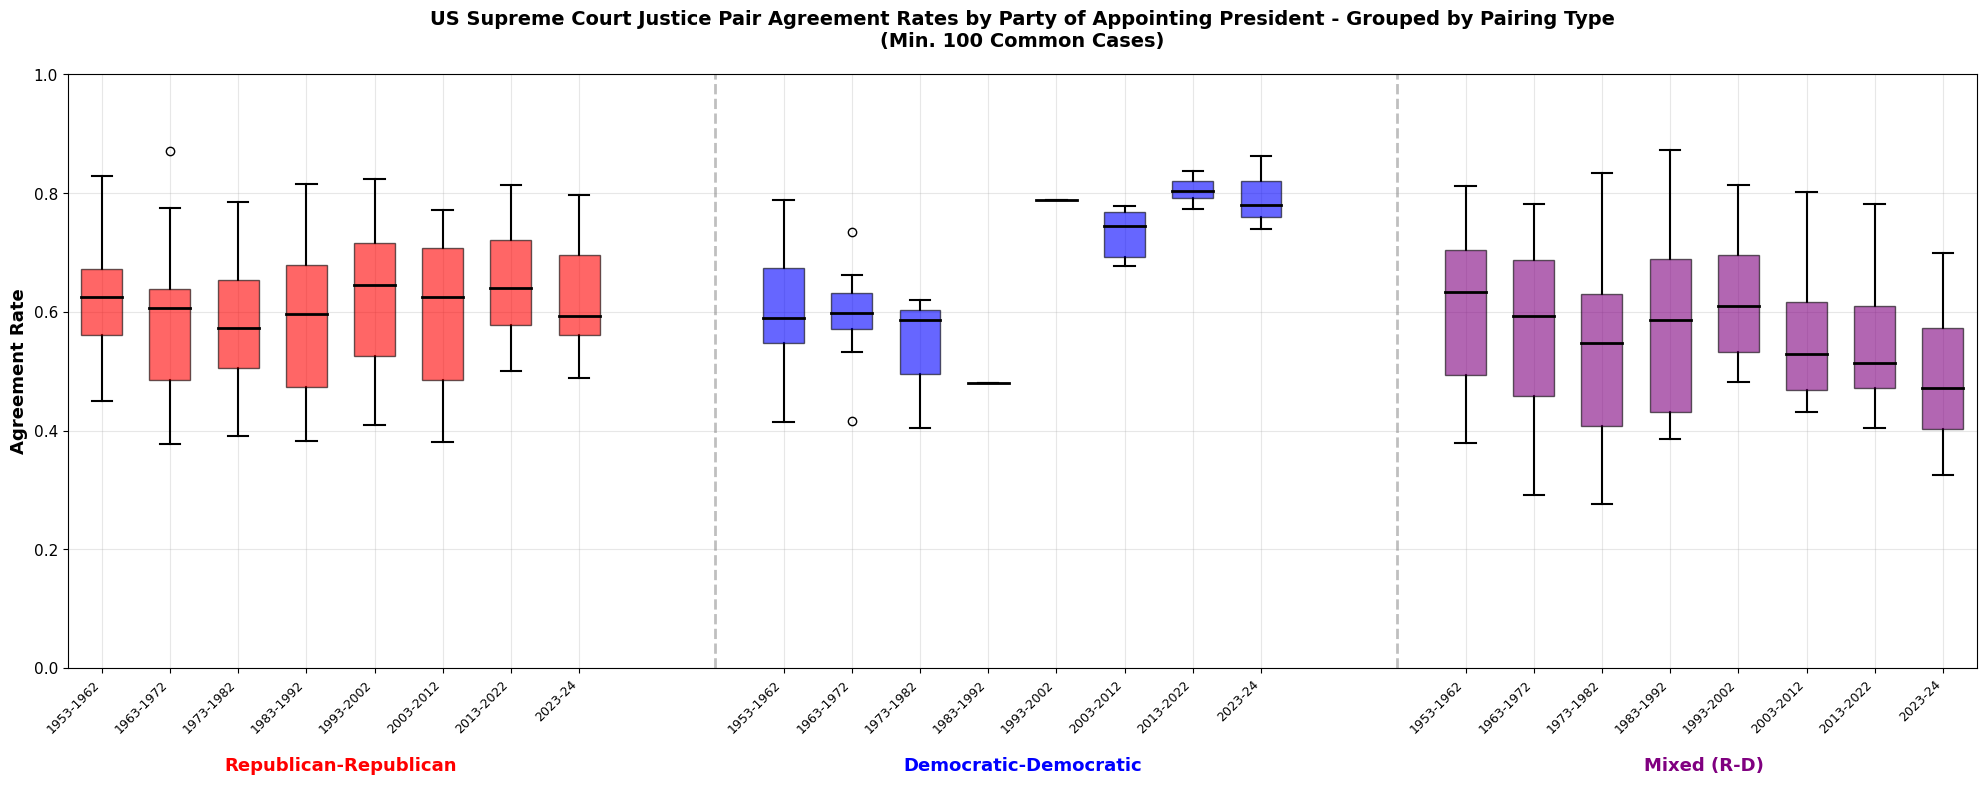


--- Summary Statistics by Pairing Type ---

Republican-Republican:
          Agreement_Rate             
                    mean    std count
Period                               
1953-1962          0.621  0.096    14
1963-1972          0.581  0.118    22
1973-1982          0.583  0.102    27
1983-1992          0.583  0.122    46
1993-2002          0.631  0.121    21
2003-2012          0.605  0.124    32
2013-2022          0.657  0.089    23
2023-24            0.628  0.094    15

Democratic-Democratic:
          Agreement_Rate             
                    mean    std count
Period                               
1953-1962          0.609  0.101    22
1963-1972          0.596  0.067    18
1973-1982          0.537  0.116     3
1983-1992          0.481    NaN     1
1993-2002          0.787    NaN     1
2003-2012          0.733  0.046     6
2013-2022          0.805  0.023     6
2023-24            0.794  0.062     3

Mixed (R-D):
          Agreement_Rate             
                    

In [11]:
def plot_partisan_agreement_grouped(df, save_path='partisan_agreement_grouped'):
    """
    Create boxplot of justice pair agreement rates grouped by partisan pairing type.
    Each pairing type shows all decades side-by-side.
    """
    print("\n--- Partisan Agreement Analysis (Grouped by Pairing Type) ---")
    
    # Define time periods
    time_periods = []
    for year in range(1953, 2023, 10):
        time_periods.append((f"{year}-{year+9}", year, year+9))
    time_periods.append(("2023-24", 2023, 2024))
    
    all_data = []
    
    for period_name, start_year, end_year in time_periods:
        print(f"Processing {period_name}...")
        period_df = df[(df['term'] >= start_year) & (df['term'] <= end_year)]
        
        if len(period_df) == 0:
            continue
        
        # Get all justice pairs
        justices = period_df['justiceName'].unique()
        
        for j1, j2 in combinations(justices, 2):
            # Get cases for each justice
            cases1 = period_df[period_df['justiceName'] == j1]
            cases2 = period_df[period_df['justiceName'] == j2]
            
            # Find common cases
            common_cases = set(cases1['caseId']) & set(cases2['caseId'])
            
            if len(common_cases) < 100:
                continue
            
            # Calculate agreement rate
            agreements = 0
            for case_id in common_cases:
                vote1 = cases1[cases1['caseId'] == case_id]['vote'].iloc[0]
                vote2 = cases2[cases2['caseId'] == case_id]['vote'].iloc[0]
                if pd.notna(vote1) and pd.notna(vote2) and vote1 == vote2:
                    agreements += 1
            
            agreement_rate = agreements / len(common_cases)
            
            # Determine partisan pairing
            party1 = get_appointing_president(j1)[1]
            party2 = get_appointing_president(j2)[1]
            
            if party1 is None or party2 is None:
                continue
            
            if party1 == 'R' and party2 == 'R':
                pair_type = 'Republican-Republican'
            elif party1 == 'D' and party2 == 'D':
                pair_type = 'Democratic-Democratic'
            else:
                pair_type = 'Mixed (R-D)'
            
            all_data.append({
                'Period': period_name,
                'Agreement_Rate': agreement_rate,
                'Pair_Type': pair_type,
                'Justice1': NAME_CLEANUP.get(j1, j1),
                'Justice2': NAME_CLEANUP.get(j2, j2),
                'N_Cases': len(common_cases)
            })
    
    if not all_data:
        print("No data found for analysis")
        return None
    
    results_df = pd.DataFrame(all_data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 8))
    
    periods = [p[0] for p in time_periods]
    pair_types = ['Republican-Republican', 'Democratic-Democratic', 'Mixed (R-D)']
    color_map = {'Republican-Republican': 'red', 
                 'Democratic-Democratic': 'blue', 
                 'Mixed (R-D)': 'purple'}
    
    box_data = []
    box_positions = []
    box_colors = []
    box_labels = []
    
    position = 0
    group_positions = []
    group_labels = []
    
    for pair_type in pair_types:
        group_start = position
        
        for period in periods:
            period_type_data = results_df[
                (results_df['Period'] == period) & 
                (results_df['Pair_Type'] == pair_type)
            ]['Agreement_Rate'].values
            
            if len(period_type_data) > 0:
                box_data.append(period_type_data)
                box_positions.append(position)
                box_colors.append(color_map[pair_type])
                box_labels.append(period)
                position += 1
            else:
                # Skip this period but keep position for alignment
                position += 1
        
        # Add space between groups
        group_positions.append((group_start + position - 1) / 2)
        group_labels.append(pair_type)
        position += 2  # Gap between groups
    
    # Create boxplot
    bp = ax.boxplot(box_data, positions=box_positions, widths=0.6,
                    patch_artist=True, showfliers=True,
                    boxprops=dict(alpha=0.7),
                    medianprops=dict(color='black', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # Add period labels on x-axis
    ax.set_xticks(box_positions)
    ax.set_xticklabels(box_labels, rotation=45, ha='right', fontsize=9)
    
    # Add group labels
    for pos, label, color in zip(group_positions, group_labels, 
                                  [color_map[pt] for pt in pair_types]):
        ax.text(pos, -0.15, label, ha='center', va='top', 
               fontsize=13, fontweight='bold', color=color,
               transform=ax.get_xaxis_transform())
    
    # Add vertical separators between groups
    separator_positions = []
    pos = 0
    for i, pair_type in enumerate(pair_types):
        n_periods = sum(1 for period in periods if 
                       len(results_df[(results_df['Period'] == period) & 
                                     (results_df['Pair_Type'] == pair_type)]) > 0)
        pos += n_periods
        if i < len(pair_types) - 1:
            separator_positions.append(pos + 1)
            pos += 2
    
    for sep_pos in separator_positions:
        ax.axvline(x=sep_pos, color='gray', linestyle='--', linewidth=2, alpha=0.5)
    
    # Formatting
    ax.set_ylabel('Agreement Rate', fontsize=13, fontweight='bold')
    ax.set_title('US Supreme Court Justice Pair Agreement Rates by Party of Appointing President - Grouped by Pairing Type\n(Min. 100 Common Cases)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    
    if save_path:
        save_figure(fig, save_path)
    
    plt.show()
    
    # Print summary statistics
    print("\n--- Summary Statistics by Pairing Type ---")
    for pair_type in pair_types:
        print(f"\n{pair_type}:")
        type_data = results_df[results_df['Pair_Type'] == pair_type]
        summary = type_data.groupby('Period').agg({
            'Agreement_Rate': ['mean', 'std', 'count']
        }).round(3)
        print(summary)
    
    return results_df

# Run the grouped analysis
partisan_grouped = plot_partisan_agreement_grouped(df)


COMPARING DIMENSIONALITY REDUCTION METHODS: 2023-2024

Filtering for justice pairs with at least 100 common cases...
Included justices: 9
Justice names: Barrett, Kavanaugh, Thomas, Kagan, Roberts, Jackson, Gorsuch, Alito, Sotomayor

--- Running MDS ---
  Stress: 0.1332
  R²: 0.9101

--- Running PCA ---
  Variance explained (PC1): 59.89%
  Variance explained (PC2): 22.06%
  Cumulative variance: 81.95%
  R²: 0.8284

--- Running t-SNE ---
  KL divergence: 0.0525
  R²: 0.8302

--- Running Hierarchical Clustering ---
  Number of clusters: 3
  Cophenetic correlation: 0.7479
Saved: assets/images/method_comparison_2023_24.png


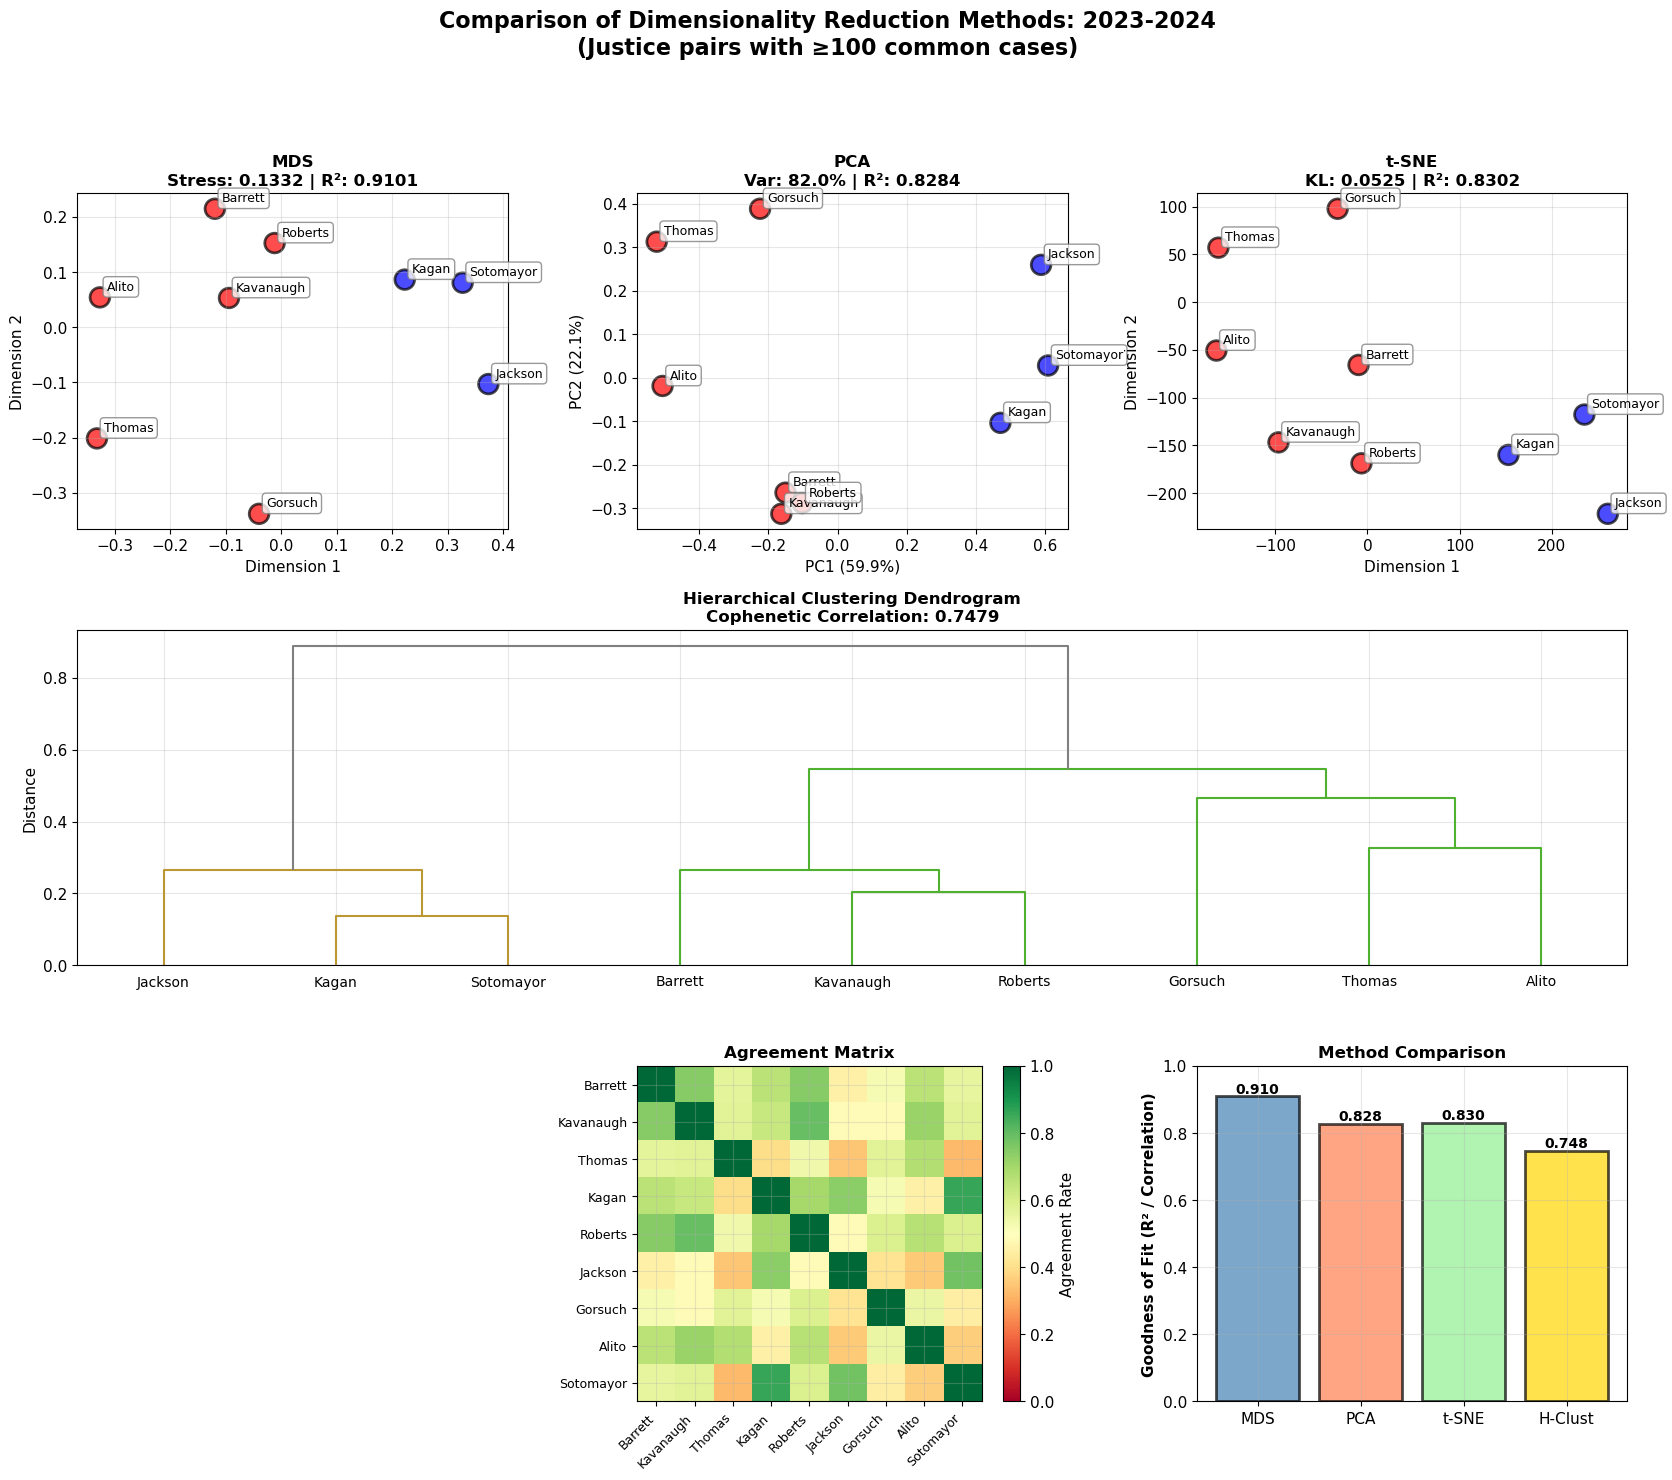


SUMMARY OF RESULTS

Data: 9 justices, minimum 100 common cases per pair

1. MDS (Multidimensional Scaling)
   - Stress: 0.1332 (Fair)
   - R²: 0.9101
   - Best for: Preserving pairwise distances

2. PCA (Principal Component Analysis)
   - Variance explained: 81.95%
   - PC1: 59.89%, PC2: 22.06%
   - R²: 0.8284
   - Best for: Finding linear structure, interpretable axes

3. t-SNE (t-Distributed Stochastic Neighbor Embedding)
   - KL divergence: 0.0525
   - R²: 0.8302
   - Best for: Revealing local structure, clusters

4. Hierarchical Clustering
   - Cophenetic correlation: 0.7479
   - Number of clusters: 3
   - Best for: Understanding grouping hierarchy

*** Best fit by R²/correlation: MDS (0.9101) ***



In [12]:
def compare_dimensionality_methods(df, start_year=2023, end_year=2024, 
                                   min_cases=100, save_path='method_comparison_2023_24'):
    """
    Compare MDS, PCA, t-SNE, and hierarchical clustering for the 2023-24 period.
    Only includes justice pairs with at least 100 common cases.
    """
    print("\n" + "="*70)
    print(f"COMPARING DIMENSIONALITY REDUCTION METHODS: {start_year}-{end_year}")
    print("="*70)
    
    period_df = df[(df['term'] >= start_year) & (df['term'] <= end_year)]
    
    # Calculate agreement matrix with min_cases filter
    print(f"\nFiltering for justice pairs with at least {min_cases} common cases...")
    
    justices = sorted(period_df['justiceName'].unique())
    n_justices = len(justices)
    
    # Build filtered agreement matrix
    justice_idx = {name: i for i, name in enumerate(justices)}
    agreements = np.zeros((n_justices, n_justices))
    comparisons = np.zeros((n_justices, n_justices))
    
    for case_id, case in period_df.groupby('caseId'):
        indices = [justice_idx[j] for j in case['justiceName']]
        votes = case['vote'].values
        
        for p1, i1 in enumerate(indices):
            for p2, i2 in enumerate(indices):
                comparisons[i1, i2] += 1
                if votes[p1] == votes[p2]:
                    agreements[i1, i2] += 1
    
    # Filter out pairs with insufficient cases
    valid_pairs = comparisons >= min_cases
    
    # Calculate agreement matrix
    with np.errstate(divide='ignore', invalid='ignore'):
        agreement_matrix = np.divide(agreements, comparisons)
        agreement_matrix = np.nan_to_num(agreement_matrix, nan=0.0)
    
    # Set invalid pairs to NaN temporarily for filtering
    agreement_matrix[~valid_pairs] = np.nan
    
    # Check which justices have sufficient data
    valid_justices_mask = ~np.all(np.isnan(agreement_matrix), axis=1)
    
    # Filter to valid justices only
    agreement_matrix = agreement_matrix[valid_justices_mask][:, valid_justices_mask]
    justices = [j for i, j in enumerate(justices) if valid_justices_mask[i]]
    
    # Replace NaN with mean for remaining pairs (if any)
    if np.any(np.isnan(agreement_matrix)):
        mean_agreement = np.nanmean(agreement_matrix)
        agreement_matrix = np.nan_to_num(agreement_matrix, nan=mean_agreement)
    
    np.fill_diagonal(agreement_matrix, 1.0)
    
    clean_names = clean_justice_names(justices)
    n_justices = len(justices)
    
    print(f"Included justices: {n_justices}")
    print(f"Justice names: {', '.join(clean_names)}")
    
    if n_justices < 3:
        print("Insufficient justices for analysis")
        return None
    
    distance_matrix = 1 - agreement_matrix
    
    # 1. MDS
    print("\n--- Running MDS ---")
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)
    
    # Calculate MDS metrics
    indices = np.triu_indices(n_justices, k=1)
    mds_distances = squareform(pdist(mds_coords))
    mds_r_squared = pearsonr(distance_matrix[indices], mds_distances[indices])[0] ** 2
    mds_stress = mds.stress_
    
    print(f"  Stress: {mds_stress:.4f}")
    print(f"  R²: {mds_r_squared:.4f}")
    
    # 2. PCA
    print("\n--- Running PCA ---")
    pca = PCA(n_components=2, random_state=42)
    pca_coords = pca.fit_transform(agreement_matrix)
    pca_variance = pca.explained_variance_ratio_
    pca_cumulative = pca_variance.sum()
    
    # Calculate PCA fit
    pca_distances = squareform(pdist(pca_coords))
    pca_r_squared = pearsonr(distance_matrix[indices], pca_distances[indices])[0] ** 2
    
    print(f"  Variance explained (PC1): {pca_variance[0]*100:.2f}%")
    print(f"  Variance explained (PC2): {pca_variance[1]*100:.2f}%")
    print(f"  Cumulative variance: {pca_cumulative*100:.2f}%")
    print(f"  R²: {pca_r_squared:.4f}")
    
    # 3. t-SNE
    print("\n--- Running t-SNE ---")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, n_justices-1), 
                metric='precomputed')
    tsne_coords = tsne.fit_transform(distance_matrix)
    
    # Calculate t-SNE fit
    tsne_distances = squareform(pdist(tsne_coords))
    tsne_r_squared = pearsonr(distance_matrix[indices], tsne_distances[indices])[0] ** 2
    tsne_kl_divergence = tsne.kl_divergence_
    
    print(f"  KL divergence: {tsne_kl_divergence:.4f}")
    print(f"  R²: {tsne_r_squared:.4f}")
    
    # 4. Hierarchical Clustering
    print("\n--- Running Hierarchical Clustering ---")
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    
    # Determine optimal number of clusters (2-4)
    n_clusters = min(3, n_justices - 1)
    clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # Calculate cophenetic correlation
    from scipy.cluster.hierarchy import cophenet
    coph_corr, _ = cophenet(linkage_matrix, squareform(distance_matrix))
    
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Cophenetic correlation: {coph_corr:.4f}")
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Color scheme
    party_colors = [('red' if get_appointing_president(j)[1] == 'R' else 
                    'blue' if get_appointing_president(j)[1] == 'D' else 'gray') 
                    for j in justices]
    
    cluster_cmap = plt.cm.Set3
    cluster_colors = [cluster_cmap(c / n_clusters) for c in clusters]
    
    # Plot 1: MDS
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(mds_coords[:, 0], mds_coords[:, 1], c=party_colors, s=200, 
               alpha=0.7, edgecolors='black', linewidth=2)
    for i, name in enumerate(clean_names):
        ax1.annotate(name, (mds_coords[i, 0], mds_coords[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            alpha=0.8, edgecolor='gray'))
    ax1.set_title(f'MDS\nStress: {mds_stress:.4f} | R²: {mds_r_squared:.4f}', 
                 fontsize=12, fontweight='bold')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: PCA
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(pca_coords[:, 0], pca_coords[:, 1], c=party_colors, s=200, 
               alpha=0.7, edgecolors='black', linewidth=2)
    for i, name in enumerate(clean_names):
        ax2.annotate(name, (pca_coords[i, 0], pca_coords[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            alpha=0.8, edgecolor='gray'))
    ax2.set_title(f'PCA\nVar: {pca_cumulative*100:.1f}% | R²: {pca_r_squared:.4f}', 
                 fontsize=12, fontweight='bold')
    ax2.set_xlabel(f'PC1 ({pca_variance[0]*100:.1f}%)')
    ax2.set_ylabel(f'PC2 ({pca_variance[1]*100:.1f}%)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: t-SNE
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=party_colors, s=200, 
               alpha=0.7, edgecolors='black', linewidth=2)
    for i, name in enumerate(clean_names):
        ax3.annotate(name, (tsne_coords[i, 0], tsne_coords[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            alpha=0.8, edgecolor='gray'))
    ax3.set_title(f't-SNE\nKL: {tsne_kl_divergence:.4f} | R²: {tsne_r_squared:.4f}', 
                 fontsize=12, fontweight='bold')
    ax3.set_xlabel('Dimension 1')
    ax3.set_ylabel('Dimension 2')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Hierarchical clustering dendrogram
    ax4 = fig.add_subplot(gs[1, :])
    dendrogram(linkage_matrix, labels=clean_names, ax=ax4, 
              leaf_font_size=10, above_threshold_color='gray')
    ax4.set_title(f'Hierarchical Clustering Dendrogram\nCophenetic Correlation: {coph_corr:.4f}', 
                 fontsize=12, fontweight='bold')
    ax4.set_ylabel('Distance')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Plot 5: MDS with clusters
#    ax5 = fig.add_subplot(gs[2, 0])
#    ax5.scatter(mds_coords[:, 0], mds_coords[:, 1], c=cluster_colors, s=200, 
#               alpha=0.7, edgecolors='black', linewidth=2)
#    for i, name in enumerate(clean_names):
#        ax5.annotate(name, (mds_coords[i, 0], mds_coords[i, 1]),
#                    xytext=(5, 5), textcoords='offset points', fontsize=9,
#                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
#                            alpha=0.8, edgecolor='gray'))
#    ax5.set_title(f'MDS + Hierarchical Clusters', fontsize=12, fontweight='bold')
#    ax5.set_xlabel('Dimension 1')
#    ax5.set_ylabel('Dimension 2')
#    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Agreement heatmap
    ax6 = fig.add_subplot(gs[2, 1])
    im = ax6.imshow(agreement_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
    ax6.set_xticks(range(n_justices))
    ax6.set_yticks(range(n_justices))
    ax6.set_xticklabels(clean_names, rotation=45, ha='right', fontsize=9)
    ax6.set_yticklabels(clean_names, fontsize=9)
    plt.colorbar(im, ax=ax6, label='Agreement Rate')
    ax6.set_title('Agreement Matrix', fontsize=12, fontweight='bold')
    
    # Plot 7: Method comparison metrics
    ax7 = fig.add_subplot(gs[2, 2])
    methods = ['MDS', 'PCA', 't-SNE', 'H-Clust']
    r_squared_values = [mds_r_squared, pca_r_squared, tsne_r_squared, coph_corr]
    
    bars = ax7.bar(methods, r_squared_values, color=['steelblue', 'coral', 'lightgreen', 'gold'],
                   alpha=0.7, edgecolor='black', linewidth=2)
    ax7.set_ylabel('Goodness of Fit (R² / Correlation)', fontsize=11, fontweight='bold')
    ax7.set_title('Method Comparison', fontsize=12, fontweight='bold')
    ax7.set_ylim(0, 1)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, r_squared_values):
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle(f'Comparison of Dimensionality Reduction Methods: {start_year}-{end_year}\n' + 
                f'(Justice pairs with ≥{min_cases} common cases)', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    
    if save_path:
        save_figure(fig, save_path)
    
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*70)
    print("SUMMARY OF RESULTS")
    print("="*70)
    
    print(f"\nData: {n_justices} justices, minimum {min_cases} common cases per pair")
    
    print("\n1. MDS (Multidimensional Scaling)")
    print(f"   - Stress: {mds_stress:.4f} ({'Excellent' if mds_stress < 0.05 else 'Good' if mds_stress < 0.1 else 'Fair' if mds_stress < 0.2 else 'Poor'})")
    print(f"   - R²: {mds_r_squared:.4f}")
    print("   - Best for: Preserving pairwise distances")
    
    print("\n2. PCA (Principal Component Analysis)")
    print(f"   - Variance explained: {pca_cumulative*100:.2f}%")
    print(f"   - PC1: {pca_variance[0]*100:.2f}%, PC2: {pca_variance[1]*100:.2f}%")
    print(f"   - R²: {pca_r_squared:.4f}")
    print("   - Best for: Finding linear structure, interpretable axes")
    
    print("\n3. t-SNE (t-Distributed Stochastic Neighbor Embedding)")
    print(f"   - KL divergence: {tsne_kl_divergence:.4f}")
    print(f"   - R²: {tsne_r_squared:.4f}")
    print("   - Best for: Revealing local structure, clusters")
    
    print("\n4. Hierarchical Clustering")
    print(f"   - Cophenetic correlation: {coph_corr:.4f}")
    print(f"   - Number of clusters: {n_clusters}")
    print("   - Best for: Understanding grouping hierarchy")
    
    # Determine best method
    best_method_idx = np.argmax([mds_r_squared, pca_r_squared, tsne_r_squared, coph_corr])
    best_methods = ['MDS', 'PCA', 't-SNE', 'Hierarchical Clustering']
    print(f"\n*** Best fit by R²/correlation: {best_methods[best_method_idx]} ({r_squared_values[best_method_idx]:.4f}) ***")
    
    print("\n" + "="*70)
    
    # Return all results
    return {
        'justices': justices,
        'clean_names': clean_names,
        'agreement_matrix': agreement_matrix,
        'distance_matrix': distance_matrix,
        'mds': {'coords': mds_coords, 'stress': mds_stress, 'r_squared': mds_r_squared},
        'pca': {'coords': pca_coords, 'variance': pca_variance, 'cumulative': pca_cumulative, 'r_squared': pca_r_squared},
        'tsne': {'coords': tsne_coords, 'kl_divergence': tsne_kl_divergence, 'r_squared': tsne_r_squared},
        'clustering': {'linkage': linkage_matrix, 'clusters': clusters, 'cophenetic': coph_corr}
    }

# Run the comparison
comparison_results = compare_dimensionality_methods(df, 2023, 2024, min_cases=100)


--- Decision Margins by Year Analysis ---

Years analyzed: 72
Total 9-justice cases: 4,869
Saved: assets/images/decision_margins_by_year.png


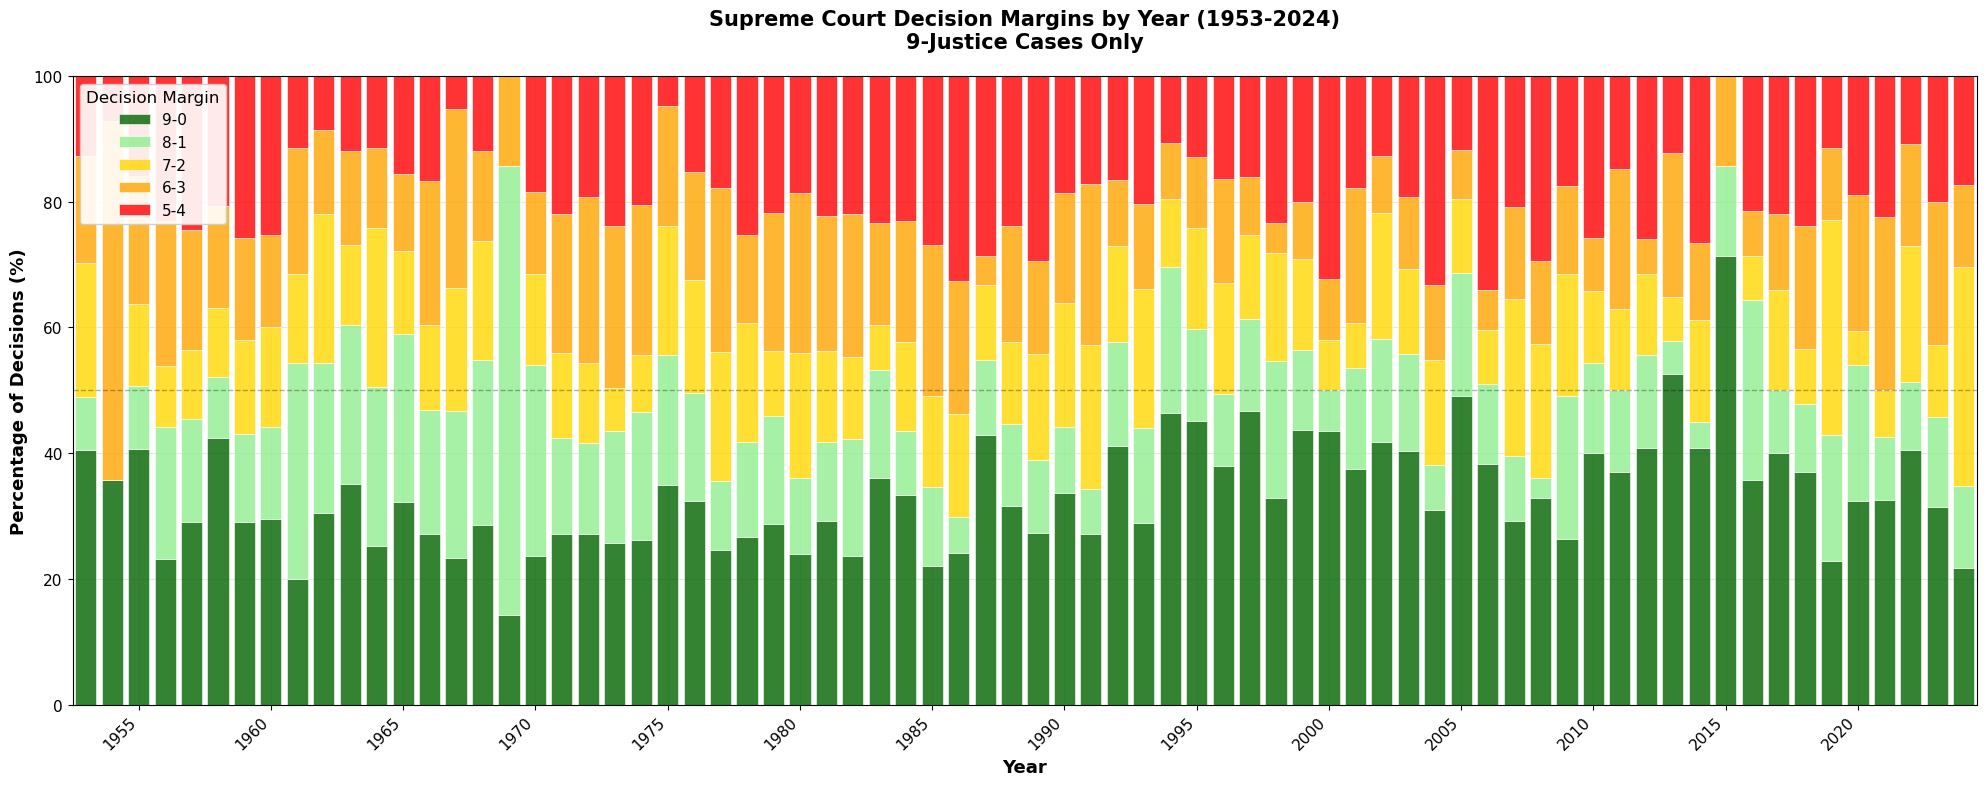


--- Overall Statistics (1953-2024) ---
Average percentage by margin:
  9-0: 33.4%
  8-1: 16.1%
  7-2: 14.6%
  6-3: 16.9%
  5-4: 18.9%

--- Decade Averages ---
         9-0   8-1   7-2   6-3   5-4
Decade                              
1950    34.3  11.4  11.5  24.2  18.6
1960    26.6  29.1  15.7  16.8  11.8
1970    27.7  17.9  14.5  20.9  18.9
1980    29.4  12.5  14.1  18.8  25.1
1990    38.4  14.8  17.0  12.7  17.2
2000    37.0  13.0  15.1  12.0  22.9
2010    41.8  13.5  12.7  13.6  18.4
2020    31.7  14.0  16.1  20.2  17.9

--- Recent Trends (Last 10 Years) ---
Years: 2015-2024
  9-0: 36.6%
  8-1: 15.3%
  7-2: 14.7%
  6-3: 16.6%
  5-4: 16.8%

--- Years with Highest Unanimity (9-0) ---
 Year       9-0  Total_Cases
 2015 71.428571           14
 2013 52.631579           57
 2005 49.019608           51
 1997 46.666667           75
 1994 46.428571           56

--- Years with Most 5-4 Decisions ---
 Year       5-4  Total_Cases
 2006 34.042553           47
 2004 33.333333           42
 1986

In [13]:
def plot_decision_margins_by_year(df, save_path='decision_margins_by_year'):
    """
    Create stacked bar chart showing percentage of decisions by margin for each year (1953-2024).
    Only includes cases with exactly 9 justices voting.
    """
    print("\n--- Decision Margins by Year Analysis ---")
    
    # Filter to 1953 onwards
    df_filtered = df[df['term'] >= 1953].copy()
    
    # Collect data by year
    yearly_data = []
    
    for year in range(1953, 2025):
        year_df = df_filtered[df_filtered['term'] == year]
        
        if len(year_df) == 0:
            continue
        
        # Count decisions by margin (only 9-justice cases)
        margin_counts = {'9-0': 0, '8-1': 0, '7-2': 0, '6-3': 0, '5-4': 0}
        
        for case_id, case_votes in year_df.groupby('caseId'):
            # Only include cases with exactly 9 justices
            if len(case_votes) != 9:
                continue
            
            vote_counts = case_votes['vote'].value_counts()
            
            if len(vote_counts) == 0:
                continue
            
            majority = vote_counts.max()
            dissent = vote_counts.iloc[1] if len(vote_counts) > 1 else 0
            
            vote_string = f"{majority}-{dissent}"
            
            if vote_string in margin_counts:
                margin_counts[vote_string] += 1
        
        total = sum(margin_counts.values())
        
        if total > 0:
            yearly_data.append({
                'Year': year,
                '9-0': margin_counts['9-0'] / total * 100,
                '8-1': margin_counts['8-1'] / total * 100,
                '7-2': margin_counts['7-2'] / total * 100,
                '6-3': margin_counts['6-3'] / total * 100,
                '5-4': margin_counts['5-4'] / total * 100,
                'Total_Cases': total
            })
    
    results_df = pd.DataFrame(yearly_data)
    
    print(f"\nYears analyzed: {len(results_df)}")
    print(f"Total 9-justice cases: {results_df['Total_Cases'].sum():,.0f}")
    
    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=(20, 8))
    
    years = results_df['Year']
    
    # Stack the bars
    bottom = np.zeros(len(results_df))
    
    margins = ['9-0', '8-1', '7-2', '6-3', '5-4']
    colors = ['darkgreen', 'lightgreen', 'gold', 'orange', 'red']
    
    for margin, color in zip(margins, colors):
        values = results_df[margin].values
        ax.bar(years, values, bottom=bottom, label=margin, 
               color=color, alpha=0.8, edgecolor='white', linewidth=0.5)
        bottom += values
    
    # Formatting
    ax.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax.set_ylabel('Percentage of Decisions (%)', fontsize=13, fontweight='bold')
    ax.set_title('Supreme Court Decision Margins by Year (1953-2024)\n9-Justice Cases Only', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_ylim(0, 100)
    ax.set_xlim(1952.5, 2024.5)
    
    # Set x-axis ticks every 5 years
    ax.set_xticks(range(1955, 2025, 5))
    ax.set_xticklabels(range(1955, 2025, 5), rotation=45, ha='right')
    
    # Add gridlines
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Legend
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9, title='Decision Margin',
             title_fontsize=12)
    
    # Add reference line at 50%
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        save_figure(fig, save_path)
    
    plt.show()
    
    # Print summary statistics
    print("\n--- Overall Statistics (1953-2024) ---")
    print(f"Average percentage by margin:")
    for margin in margins:
        avg_pct = results_df[margin].mean()
        print(f"  {margin}: {avg_pct:.1f}%")
    
    print("\n--- Decade Averages ---")
    results_df['Decade'] = (results_df['Year'] // 10) * 10
    decade_summary = results_df.groupby('Decade')[margins].mean().round(1)
    print(decade_summary)
    
    print("\n--- Recent Trends (Last 10 Years) ---")
    recent = results_df[results_df['Year'] >= 2015]
    if len(recent) > 0:
        print(f"Years: {recent['Year'].min()}-{recent['Year'].max()}")
        for margin in margins:
            avg_pct = recent[margin].mean()
            print(f"  {margin}: {avg_pct:.1f}%")
    
    print("\n--- Years with Highest Unanimity (9-0) ---")
    top_unanimous = results_df.nlargest(5, '9-0')[['Year', '9-0', 'Total_Cases']]
    print(top_unanimous.to_string(index=False))
    
    print("\n--- Years with Most 5-4 Decisions ---")
    top_split = results_df.nlargest(5, '5-4')[['Year', '5-4', 'Total_Cases']]
    print(top_split.to_string(index=False))
    
    return results_df

# Run the analysis
margins_by_year = plot_decision_margins_by_year(df)


--- Justice Pair Agreement Analysis (1953-2024) ---
Minimum common cases required: 100

Total justices in dataset: 37

Calculating pairwise agreements...
Valid justice pairs analyzed: 244
Saved: assets/images/justice_pair_agreements_boxplot.png


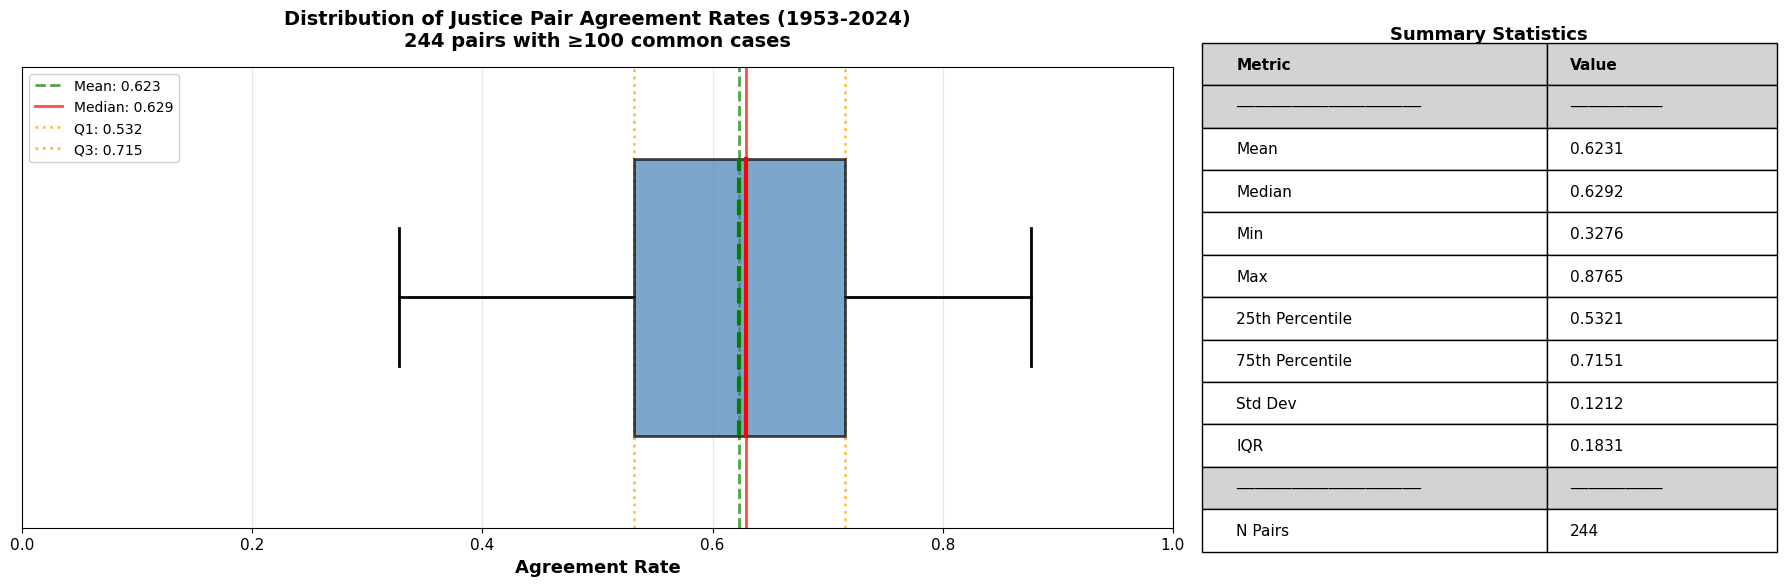


SUMMARY STATISTICS

Overall Agreement Rates:
  Mean:             0.6231 (62.31%)
  Median:           0.6292 (62.92%)
  Standard Dev:     0.1212
  Min:              0.3276 (32.76%)
  Max:              0.8765 (87.65%)
  25th Percentile:  0.5321 (53.21%)
  75th Percentile:  0.7151 (71.51%)
  IQR:              0.1831

BREAKDOWN BY PAIR TYPE

Republican-Republican:
  Number of pairs:  90
  Mean agreement:   0.6281 (62.81%)
  Median agreement: 0.6309 (63.09%)
  Std Dev:          0.1124

Democratic-Democratic:
  Number of pairs:  38
  Mean agreement:   0.6791 (67.91%)
  Median agreement: 0.6817 (68.17%)
  Std Dev:          0.1068

Mixed (R-D):
  Number of pairs:  116
  Mean agreement:   0.6008 (60.08%)
  Median agreement: 0.5996 (59.96%)
  Std Dev:          0.1267

MOST AGREEABLE JUSTICE PAIRS
Justice1  Justice2  Agreement_Rate  N_Cases             Pair_Type
  Warren   Brennan        0.876483     1854 Republican-Republican
 Brennan  Marshall        0.872377     3526           Mixed (R-D)
  W

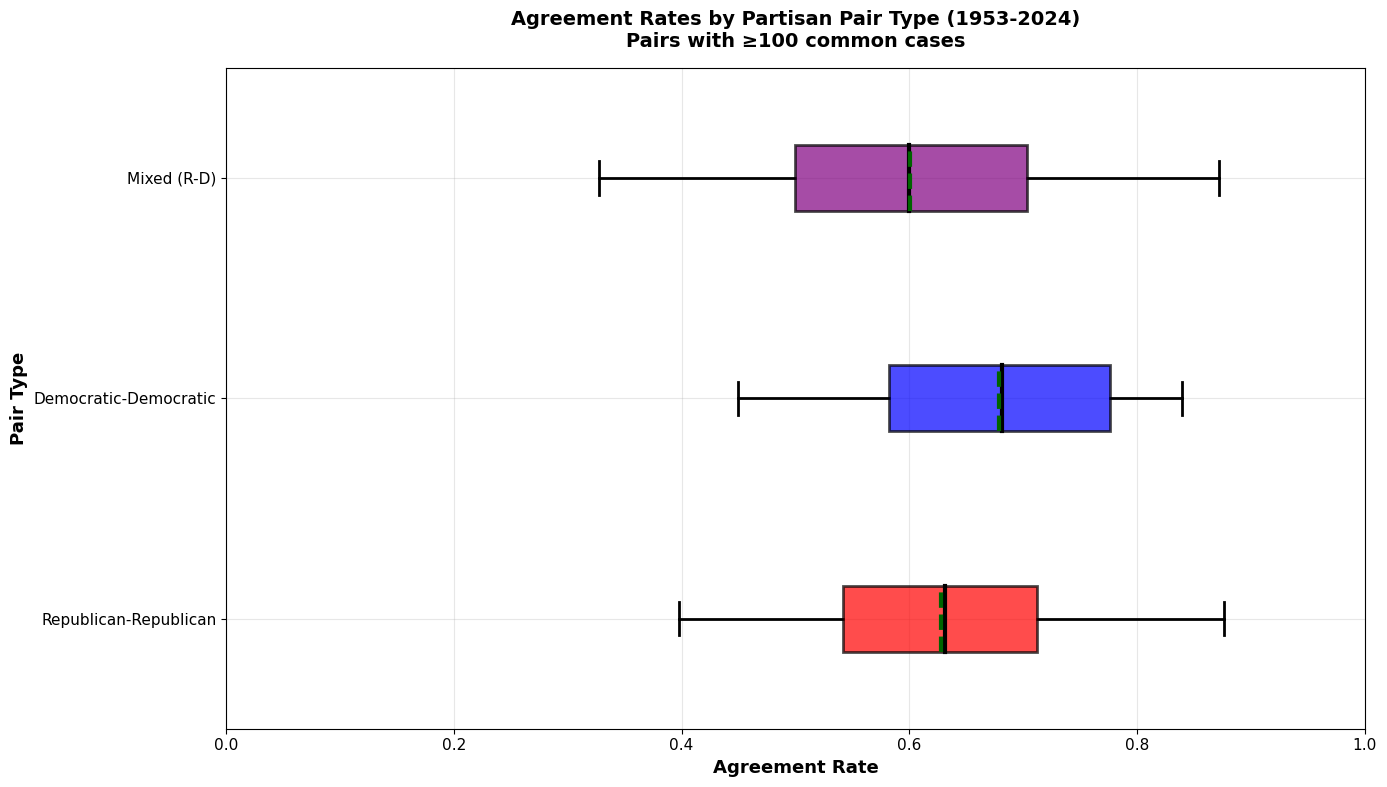

In [14]:
def analyze_all_justice_pair_agreements(df, min_cases=100, save_path='justice_pair_agreements_boxplot'):
    """
    Create horizontal boxplot and summary statistics for agreement rates among all justice pairs
    with at least 100 common cases (1953-2024).
    """
    print("\n--- Justice Pair Agreement Analysis (1953-2024) ---")
    print(f"Minimum common cases required: {min_cases}")
    
    # Filter to 1953 onwards
    df_filtered = df[df['term'] >= 1953].copy()
    
    # Get all unique justices
    all_justices = df_filtered['justiceName'].unique()
    
    print(f"\nTotal justices in dataset: {len(all_justices)}")
    
    # Calculate agreement rates for all pairs
    pair_agreements = []
    
    print("\nCalculating pairwise agreements...")
    
    for j1, j2 in combinations(all_justices, 2):
        # Get cases for each justice
        cases1 = df_filtered[df_filtered['justiceName'] == j1]
        cases2 = df_filtered[df_filtered['justiceName'] == j2]
        
        # Find common cases
        common_cases = set(cases1['caseId']) & set(cases2['caseId'])
        
        if len(common_cases) < min_cases:
            continue
        
        # Calculate agreement rate
        agreements = 0
        valid_cases = 0
        
        for case_id in common_cases:
            vote1 = cases1[cases1['caseId'] == case_id]['vote'].iloc[0]
            vote2 = cases2[cases2['caseId'] == case_id]['vote'].iloc[0]
            
            if pd.notna(vote1) and pd.notna(vote2):
                valid_cases += 1
                if vote1 == vote2:
                    agreements += 1
        
        if valid_cases >= min_cases:
            agreement_rate = agreements / valid_cases
            
            # Get party information
            party1 = get_appointing_president(j1)[1]
            party2 = get_appointing_president(j2)[1]
            
            if party1 is None or party2 is None:
                pair_type = 'Unknown'
            elif party1 == 'R' and party2 == 'R':
                pair_type = 'Republican-Republican'
            elif party1 == 'D' and party2 == 'D':
                pair_type = 'Democratic-Democratic'
            else:
                pair_type = 'Mixed (R-D)'
            
            pair_agreements.append({
                'Justice1': NAME_CLEANUP.get(j1, j1),
                'Justice2': NAME_CLEANUP.get(j2, j2),
                'Agreement_Rate': agreement_rate,
                'N_Cases': valid_cases,
                'Pair_Type': pair_type
            })
    
    results_df = pd.DataFrame(pair_agreements)
    
    print(f"Valid justice pairs analyzed: {len(results_df):,}")
    
    if len(results_df) == 0:
        print("No justice pairs found with sufficient common cases")
        return None
    
    # Calculate summary statistics
    stats = {
        'Mean': results_df['Agreement_Rate'].mean(),
        'Median': results_df['Agreement_Rate'].median(),
        'Min': results_df['Agreement_Rate'].min(),
        'Max': results_df['Agreement_Rate'].max(),
        '25th Percentile': results_df['Agreement_Rate'].quantile(0.25),
        '75th Percentile': results_df['Agreement_Rate'].quantile(0.75),
        'Std Dev': results_df['Agreement_Rate'].std(),
        'IQR': results_df['Agreement_Rate'].quantile(0.75) - results_df['Agreement_Rate'].quantile(0.25)
    }
    
    # Create figure with boxplot and statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), 
                                     gridspec_kw={'width_ratios': [2, 1]})
    
    # ===== Horizontal Boxplot =====
    bp = ax1.boxplot([results_df['Agreement_Rate']], 
                      vert=False, 
                      widths=0.6,
                      patch_artist=True,
                      showmeans=True,
                      meanline=True,
                      boxprops=dict(facecolor='steelblue', alpha=0.7, linewidth=2),
                      whiskerprops=dict(linewidth=2),
                      capprops=dict(linewidth=2),
                      medianprops=dict(color='red', linewidth=3),
                      meanprops=dict(color='green', linewidth=3, linestyle='--'),
                      flierprops=dict(marker='o', markerfacecolor='coral', markersize=6, 
                                     alpha=0.5, markeredgecolor='darkred'))
    
    ax1.set_xlabel('Agreement Rate', fontsize=13, fontweight='bold')
    ax1.set_title(f'Distribution of Justice Pair Agreement Rates (1953-2024)\n' + 
                  f'{len(results_df):,} pairs with ≥{min_cases} common cases',
                  fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlim(0, 1)
    ax1.set_yticks([])
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add vertical lines for key statistics
    ax1.axvline(stats['Mean'], color='green', linestyle='--', linewidth=2, 
                alpha=0.7, label=f"Mean: {stats['Mean']:.3f}")
    ax1.axvline(stats['Median'], color='red', linestyle='-', linewidth=2, 
                alpha=0.7, label=f"Median: {stats['Median']:.3f}")
    ax1.axvline(stats['25th Percentile'], color='orange', linestyle=':', linewidth=2, 
                alpha=0.7, label=f"Q1: {stats['25th Percentile']:.3f}")
    ax1.axvline(stats['75th Percentile'], color='orange', linestyle=':', linewidth=2, 
                alpha=0.7, label=f"Q3: {stats['75th Percentile']:.3f}")
    
    ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
    
    # ===== Statistics Table =====
    ax2.axis('off')
    
    # Create statistics table
    table_data = []
    table_data.append(['Metric', 'Value'])
    table_data.append(['─' * 20, '─' * 10])
    table_data.append(['Mean', f'{stats["Mean"]:.4f}'])
    table_data.append(['Median', f'{stats["Median"]:.4f}'])
    table_data.append(['Min', f'{stats["Min"]:.4f}'])
    table_data.append(['Max', f'{stats["Max"]:.4f}'])
    table_data.append(['25th Percentile', f'{stats["25th Percentile"]:.4f}'])
    table_data.append(['75th Percentile', f'{stats["75th Percentile"]:.4f}'])
    table_data.append(['Std Dev', f'{stats["Std Dev"]:.4f}'])
    table_data.append(['IQR', f'{stats["IQR"]:.4f}'])
    table_data.append(['─' * 20, '─' * 10])
    table_data.append(['N Pairs', f'{len(results_df):,}'])
    
    table = ax2.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Style the table
    for i in range(len(table_data)):
        cell = table[(i, 0)]
        cell.set_facecolor('lightgray' if i in [0, 1, 10] else 'white')
        cell.set_text_props(weight='bold' if i == 0 else 'normal')
        
        cell = table[(i, 1)]
        cell.set_facecolor('lightgray' if i in [0, 1, 10] else 'white')
        cell.set_text_props(weight='bold' if i == 0 else 'normal')
    
    ax2.set_title('Summary Statistics', fontsize=13, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        save_figure(fig, save_path)
    
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    print(f"\nOverall Agreement Rates:")
    print(f"  Mean:             {stats['Mean']:.4f} ({stats['Mean']*100:.2f}%)")
    print(f"  Median:           {stats['Median']:.4f} ({stats['Median']*100:.2f}%)")
    print(f"  Standard Dev:     {stats['Std Dev']:.4f}")
    print(f"  Min:              {stats['Min']:.4f} ({stats['Min']*100:.2f}%)")
    print(f"  Max:              {stats['Max']:.4f} ({stats['Max']*100:.2f}%)")
    print(f"  25th Percentile:  {stats['25th Percentile']:.4f} ({stats['25th Percentile']*100:.2f}%)")
    print(f"  75th Percentile:  {stats['75th Percentile']:.4f} ({stats['75th Percentile']*100:.2f}%)")
    print(f"  IQR:              {stats['IQR']:.4f}")
    
    # Breakdown by pair type
    print("\n" + "="*70)
    print("BREAKDOWN BY PAIR TYPE")
    print("="*70)
    
    for pair_type in ['Republican-Republican', 'Democratic-Democratic', 'Mixed (R-D)']:
        subset = results_df[results_df['Pair_Type'] == pair_type]
        if len(subset) > 0:
            print(f"\n{pair_type}:")
            print(f"  Number of pairs:  {len(subset):,}")
            print(f"  Mean agreement:   {subset['Agreement_Rate'].mean():.4f} ({subset['Agreement_Rate'].mean()*100:.2f}%)")
            print(f"  Median agreement: {subset['Agreement_Rate'].median():.4f} ({subset['Agreement_Rate'].median()*100:.2f}%)")
            print(f"  Std Dev:          {subset['Agreement_Rate'].std():.4f}")
    
    # Most and least agreeable pairs
    print("\n" + "="*70)
    print("MOST AGREEABLE JUSTICE PAIRS")
    print("="*70)
    top_pairs = results_df.nlargest(10, 'Agreement_Rate')
    print(top_pairs[['Justice1', 'Justice2', 'Agreement_Rate', 'N_Cases', 'Pair_Type']].to_string(index=False))
    
    print("\n" + "="*70)
    print("LEAST AGREEABLE JUSTICE PAIRS")
    print("="*70)
    bottom_pairs = results_df.nsmallest(10, 'Agreement_Rate')
    print(bottom_pairs[['Justice1', 'Justice2', 'Agreement_Rate', 'N_Cases', 'Pair_Type']].to_string(index=False))
    
    # Create additional boxplot by pair type
    fig2, ax = plt.subplots(figsize=(14, 8))
    
    pair_types = ['Republican-Republican', 'Democratic-Democratic', 'Mixed (R-D)']
    data_by_type = [results_df[results_df['Pair_Type'] == pt]['Agreement_Rate'].values 
                    for pt in pair_types]
    colors = ['red', 'blue', 'purple']
    
    bp2 = ax.boxplot(data_by_type, 
                     labels=pair_types,
                     vert=False,
                     patch_artist=True,
                     showmeans=True,
                     meanline=True,
                     boxprops=dict(alpha=0.7, linewidth=2),
                     whiskerprops=dict(linewidth=2),
                     capprops=dict(linewidth=2),
                     medianprops=dict(color='black', linewidth=3),
                     meanprops=dict(color='darkgreen', linewidth=3, linestyle='--'))
    
    # Color boxes by pair type
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xlabel('Agreement Rate', fontsize=13, fontweight='bold')
    ax.set_ylabel('Pair Type', fontsize=13, fontweight='bold')
    ax.set_title(f'Agreement Rates by Partisan Pair Type (1953-2024)\n' +
                 f'Pairs with ≥{min_cases} common cases',
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    if save_path:
        save_figure(fig2, save_path + '_by_type')
    
    plt.show()
    
    return results_df

# Run the analysis
all_pairs_analysis = analyze_all_justice_pair_agreements(df, min_cases=100)


--- Justices Served by Year Analysis ---
Saved: assets/images/justices_served_by_year.png


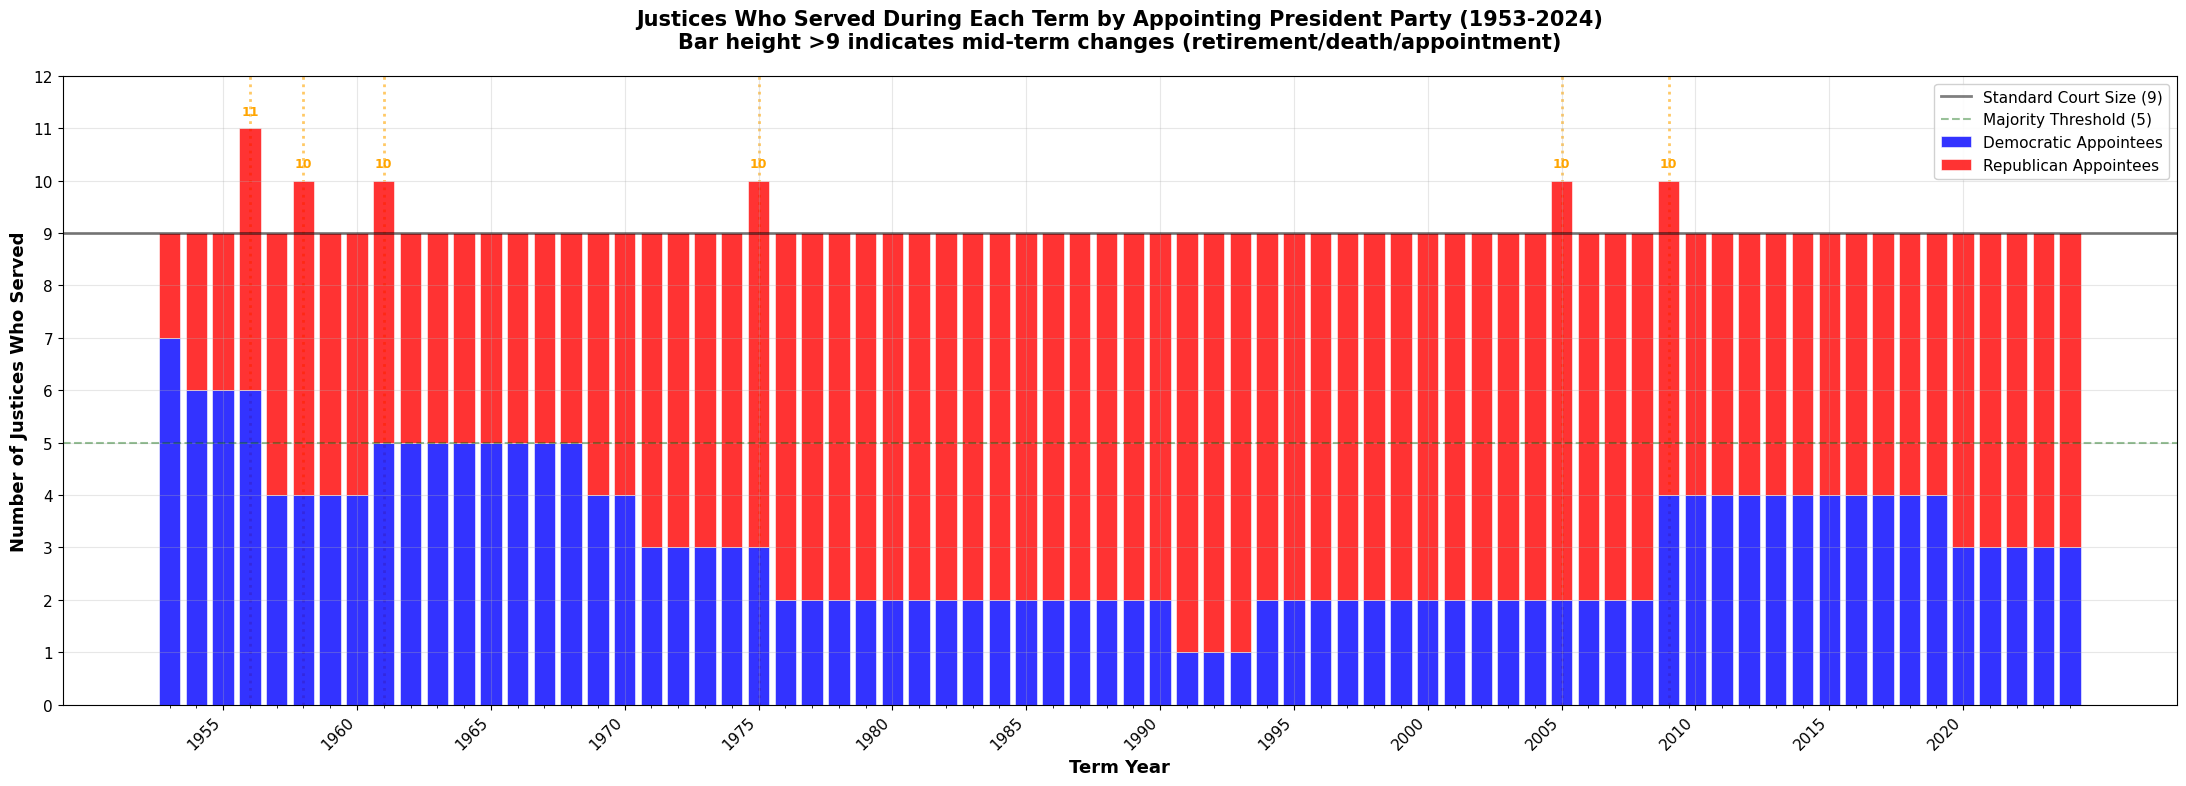


SUMMARY STATISTICS

Total terms analyzed: 72
Years with standard 9 justices: 66
Years with <9 justices: 0
Years with >9 justices (mid-term changes): 6

YEARS WITH MID-TERM CHANGES (>9 Justices)
 Term  Total_Justices  Republican_Count  Democratic_Count
 1956              11                 5                 6
 1958              10                 6                 4
 1961              10                 5                 5
 1975              10                 7                 3
 2005              10                 8                 2
 2009              10                 6                 4

YEARS WITH FEWER THAN 9 JUSTICES
No years with <9 justices found

PARTISAN BALANCE OVER TIME

Years with Republican majority: 60
Years with Democratic majority: 11
Years with tied court: 1

Most Republican justices in one term:
  Year: 1991
  Republican justices: 8
  Democratic justices: 1

Most Democratic justices in one term:
  Year: 1953
  Democratic justices: 7
  Republican justices: 2

DECA

In [15]:
def plot_justices_served_by_year(df, save_path='justices_served_by_year'):
    """
    Create stacked bar chart showing number of justices who served all or part of each term (1953-2024).
    Red for Republican appointees, Blue for Democratic appointees.
    Bar height can exceed 9 in years with retirements/deaths.
    """
    print("\n--- Justices Served by Year Analysis ---")
    
    # Get all terms from 1953 onwards
    terms = sorted(df[df['term'] >= 1953]['term'].unique())
    
    composition_data = []
    
    for term in terms:
        term_df = df[df['term'] == term]
        justices_in_term = term_df['justiceName'].unique()
        
        # Count by party
        republican_justices = []
        democratic_justices = []
        unknown_justices = []
        
        for justice in justices_in_term:
            party = get_appointing_president(justice)[1]
            if party == 'R':
                republican_justices.append(justice)
            elif party == 'D':
                democratic_justices.append(justice)
            else:
                unknown_justices.append(justice)
        
        composition_data.append({
            'Term': term,
            'Republican_Count': len(republican_justices),
            'Democratic_Count': len(democratic_justices),
            'Unknown_Count': len(unknown_justices),
            'Total_Justices': len(justices_in_term),
            'Republican_Names': ', '.join([NAME_CLEANUP.get(j, j) for j in republican_justices]),
            'Democratic_Names': ', '.join([NAME_CLEANUP.get(j, j) for j in democratic_justices])
        })
    
    comp_df = pd.DataFrame(composition_data)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(22, 8))
    
    # Create stacked bar chart
    x = comp_df['Term']
    republican = comp_df['Republican_Count']
    democratic = comp_df['Democratic_Count']
    unknown = comp_df['Unknown_Count']
    
    # Plot stacked bars
    bars_dem = ax.bar(x, democratic, label='Democratic Appointees', 
                      color='blue', alpha=0.8, edgecolor='white', linewidth=0.5)
    bars_rep = ax.bar(x, republican, bottom=democratic, label='Republican Appointees', 
                      color='red', alpha=0.8, edgecolor='white', linewidth=0.5)
    
    if unknown.sum() > 0:
        ax.bar(x, unknown, bottom=republican + democratic, 
               label='Unknown', color='gray', alpha=0.8, edgecolor='white', linewidth=0.5)
    
    # Add reference lines
    ax.axhline(y=9, color='black', linestyle='-', linewidth=2, alpha=0.5, 
               label='Standard Court Size (9)')
    ax.axhline(y=5, color='darkgreen', linestyle='--', linewidth=1.5, alpha=0.4, 
               label='Majority Threshold (5)')
    
    # Formatting
    ax.set_xlabel('Term Year', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Justices Who Served', fontsize=13, fontweight='bold')
    ax.set_title('Justices Who Served During Each Term by Appointing President Party (1953-2024)\n' +
                 'Bar height >9 indicates mid-term changes (retirement/death/appointment)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_ylim(0, max(comp_df['Total_Justices'].max() + 1, 11))
    ax.set_yticks(range(0, int(max(comp_df['Total_Justices'].max() + 1, 11)) + 1))
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
    
    # Show every year on x-axis but only label every 5 years
    ax.set_xticks(range(min(terms), max(terms) + 1, 1), minor=True)
    ax.set_xticks(range(1955, max(terms) + 1, 5))
    ax.set_xticklabels(range(1955, max(terms) + 1, 5), rotation=45, ha='right')
    
    # Highlight years with more than 9 justices
    years_with_changes = comp_df[comp_df['Total_Justices'] > 9]
    for _, row in years_with_changes.iterrows():
        ax.axvline(x=row['Term'], color='orange', linestyle=':', 
                  linewidth=2, alpha=0.6, zorder=0)
        # Add annotation for significant changes
        ax.text(row['Term'], row['Total_Justices'] + 0.2, 
               f"{int(row['Total_Justices'])}", 
               ha='center', va='bottom', fontsize=9, fontweight='bold',
               color='orange')
    
    plt.tight_layout()
    
    if save_path:
        save_figure(fig, save_path)
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    print(f"\nTotal terms analyzed: {len(comp_df)}")
    print(f"Years with standard 9 justices: {(comp_df['Total_Justices'] == 9).sum()}")
    print(f"Years with <9 justices: {(comp_df['Total_Justices'] < 9).sum()}")
    print(f"Years with >9 justices (mid-term changes): {(comp_df['Total_Justices'] > 9).sum()}")
    
    print("\n" + "="*70)
    print("YEARS WITH MID-TERM CHANGES (>9 Justices)")
    print("="*70)
    
    if len(years_with_changes) > 0:
        print(years_with_changes[['Term', 'Total_Justices', 'Republican_Count', 
                                  'Democratic_Count']].to_string(index=False))
    else:
        print("No years with >9 justices found")
    
    print("\n" + "="*70)
    print("YEARS WITH FEWER THAN 9 JUSTICES")
    print("="*70)
    
    years_understaffed = comp_df[comp_df['Total_Justices'] < 9]
    if len(years_understaffed) > 0:
        print(years_understaffed[['Term', 'Total_Justices', 'Republican_Count', 
                                  'Democratic_Count']].to_string(index=False))
    else:
        print("No years with <9 justices found")
    
    print("\n" + "="*70)
    print("PARTISAN BALANCE OVER TIME")
    print("="*70)
    
    print(f"\nYears with Republican majority: {(comp_df['Republican_Count'] > comp_df['Democratic_Count']).sum()}")
    print(f"Years with Democratic majority: {(comp_df['Democratic_Count'] > comp_df['Republican_Count']).sum()}")
    print(f"Years with tied court: {(comp_df['Republican_Count'] == comp_df['Democratic_Count']).sum()}")
    
    # Most Republican and most Democratic years
    most_rep_year = comp_df.loc[comp_df['Republican_Count'].idxmax()]
    most_dem_year = comp_df.loc[comp_df['Democratic_Count'].idxmax()]
    
    print(f"\nMost Republican justices in one term:")
    print(f"  Year: {int(most_rep_year['Term'])}")
    print(f"  Republican justices: {int(most_rep_year['Republican_Count'])}")
    print(f"  Democratic justices: {int(most_rep_year['Democratic_Count'])}")
    
    print(f"\nMost Democratic justices in one term:")
    print(f"  Year: {int(most_dem_year['Term'])}")
    print(f"  Democratic justices: {int(most_dem_year['Democratic_Count'])}")
    print(f"  Republican justices: {int(most_dem_year['Republican_Count'])}")
    
    print("\n" + "="*70)
    print("DECADE AVERAGES")
    print("="*70)
    
    comp_df['Decade'] = (comp_df['Term'] // 10) * 10
    decade_summary = comp_df.groupby('Decade').agg({
        'Republican_Count': 'mean',
        'Democratic_Count': 'mean',
        'Total_Justices': 'mean'
    }).round(2)
    decade_summary.columns = ['Avg_Republican', 'Avg_Democratic', 'Avg_Total']
    print(decade_summary)
    
    # Create detailed view of transition years
    print("\n" + "="*70)
    print("DETAILED VIEW: YEARS WITH MID-TERM CHANGES")
    print("="*70)
    
    for _, row in years_with_changes.iterrows():
        print(f"\nTerm {int(row['Term'])}:")
        print(f"  Total justices who served: {int(row['Total_Justices'])}")
        print(f"  Republican appointees ({int(row['Republican_Count'])}): {row['Republican_Names']}")
        print(f"  Democratic appointees ({int(row['Democratic_Count'])}): {row['Democratic_Names']}")
    
    return comp_df

# Run the analysis
justices_served_df = plot_justices_served_by_year(df)